# **RNN Tutorial: Predicting Stress from Strain and Volume Fraction**

## **Introduction**

Recurrent Neural Networks (RNNs) are designed to handle sequential data by maintaining memory of previous inputs. In this tutorial, we apply an RNN to predict stress from strain and volume fraction in a material, treating each stress–strain curve as a sequence.

---

## **Problem Statement**

We are given a dataset containing:

- **Volume Fraction (%):** Material composition parameter
- **Strain:** Material deformation  
- **Stress (MPa):** Applied mechanical force  (target to predict)


For each volume fraction, we observe a stress–strain curve, which we treat as a time-like sequence. Our objectives are:

1. **Train an RNN** to predict stress from sequential strain and volume fraction data.
2. **Visualize predicted vs. true stress–strain curves** for each volume fraction.
3. **Evaluate performance** using R² score, MAE, and MSE.
4. **Compare with a Feedforward Neural Network (FFNN)** to see the benefit of sequence learning.

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Step 01: Import Libraries and Set Up Device**



In [ ]:
# Import essential libraries
import pandas as pd                        # For data handling (CSV, DataFrame)
import torch                               # Core PyTorch library
import torch.nn as nn                      # Neural network modules (layers, activations, etc.)
from torch.utils.data import Dataset, DataLoader  # Tools for handling datasets and batching
from sklearn.preprocessing import MinMaxScaler    # For feature normalization (scaling 0–1)
import matplotlib.pyplot as plt            # For plotting and visualization
import numpy as np                         # For numerical operations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics

# Set up the device (use GPU if available, otherwise fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Step 02: Load and Preprocess the Stress–Strain Dataset**

In this step, we load the CSV file containing experimental stress–strain data for different volume fractions. We sort the data to preserve the sequence within each volume fraction, normalize the inputs and outputs using MinMaxScaler, and create scaled versions of each column to use in model training.

In [ ]:
# Load the cleaned dataset
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/RNN/stress_strain_dataset.csv")

# Sort the data so each volume fraction's stress–strain curve is sequential
df = df.sort_values(by=["Volume_Fraction", "Strain"])

# Separate the input features (Volume Fraction, Strain) and target output (Stress)
X_raw = df[['Volume_Fraction', 'Strain']].values  # Input features
y_raw = df[['Stress']].values                     # Target stress

# Initialize scalers for input and output normalization
scaler_x = MinMaxScaler()   # For Volume Fraction and Strain
scaler_y = MinMaxScaler()   # For Stress

# Normalize the input and output to range [0, 1]
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Store normalized columns in the original DataFrame for easy access
df['X1'] = X_scaled[:, 0]       # Scaled Volume Fraction
df['X2'] = X_scaled[:, 1]       # Scaled Strain
df['y_scaled'] = y_scaled[:, 0] # Scaled Stress

## **Visualize True Stress–Strain Curves by Volume Fraction**

Before training our RNN, it's important to understand the structure of the data. Each volume fraction corresponds to a unique stress–strain curve. In this step, we plot the actual (true) stress–strain curves for each volume fraction to observe their behavior.

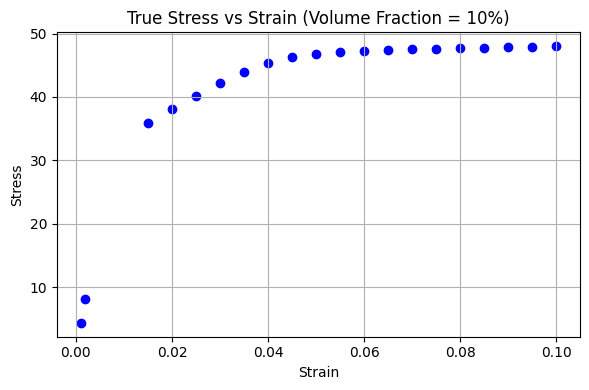

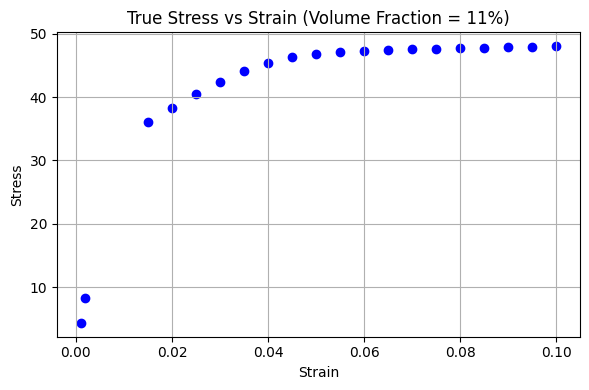

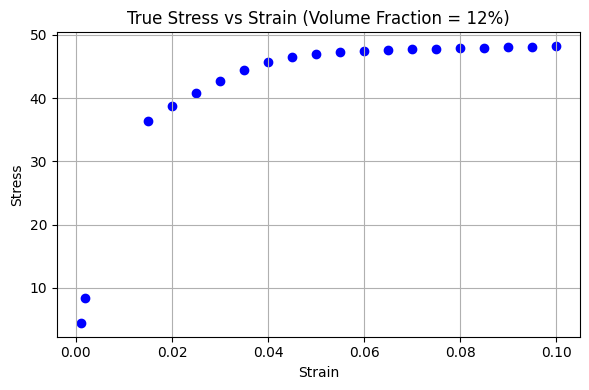

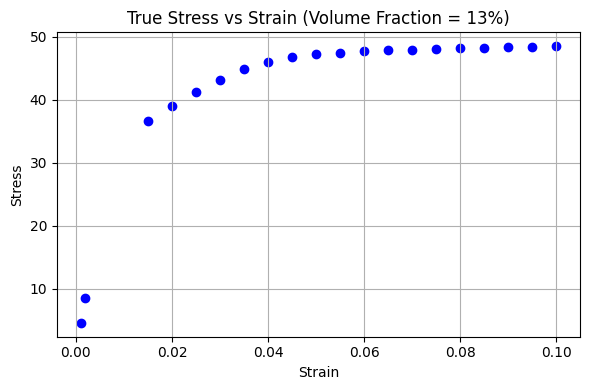

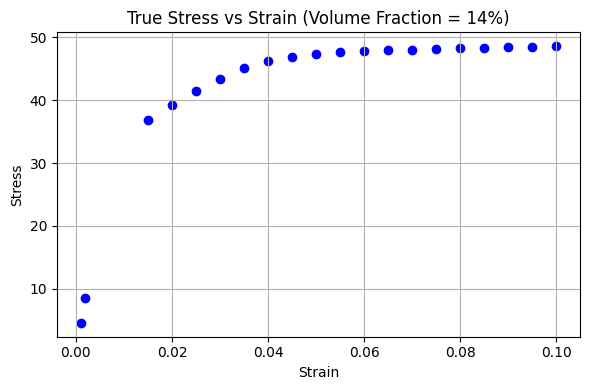

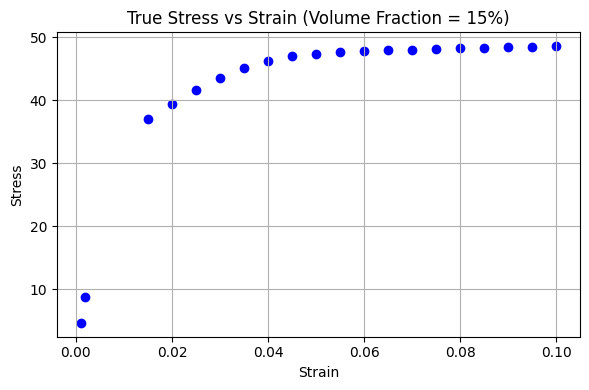

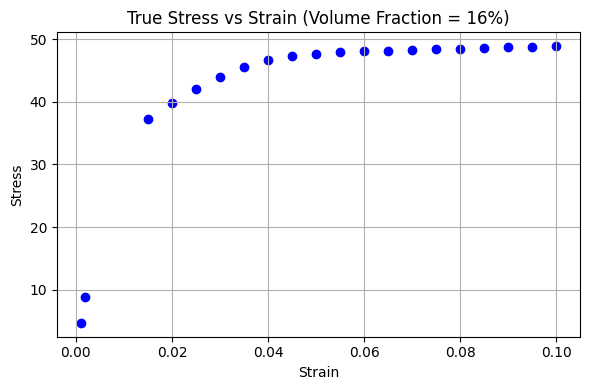

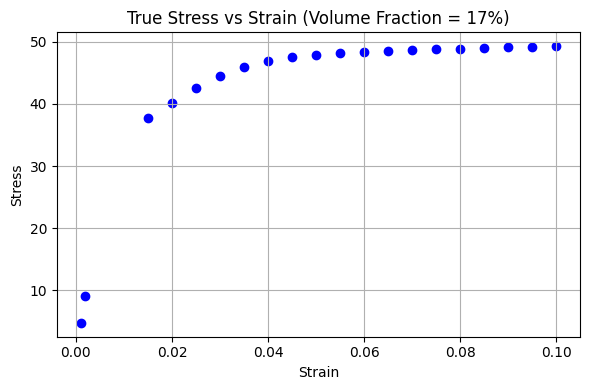

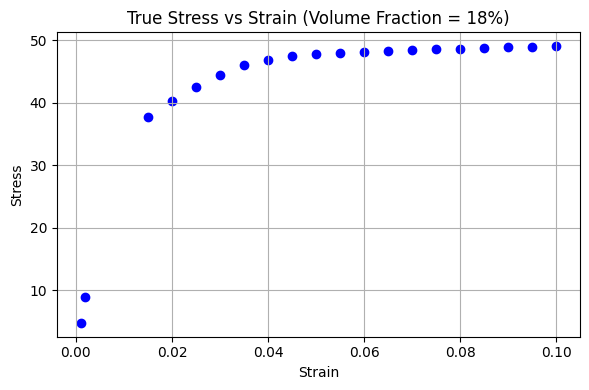

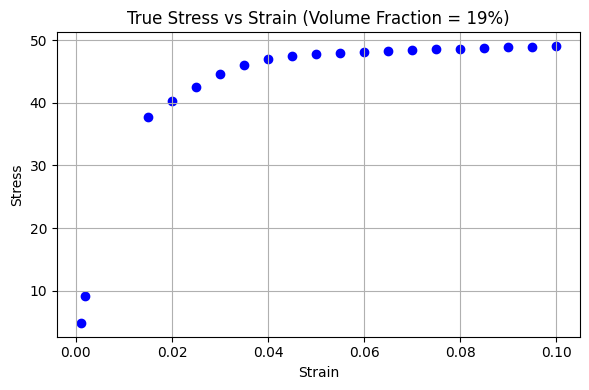

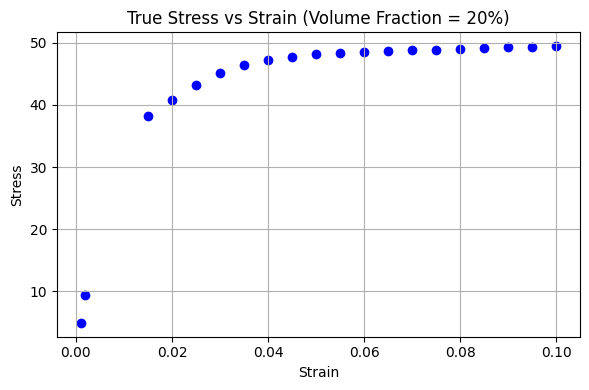

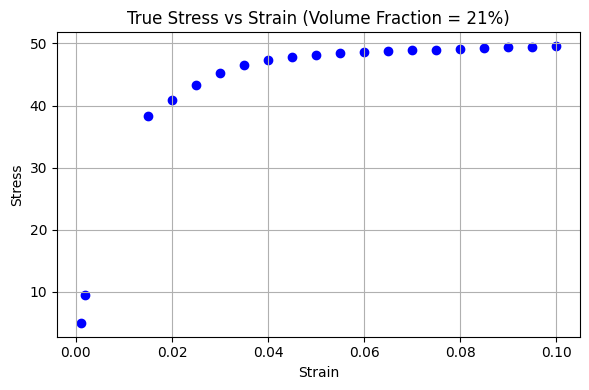

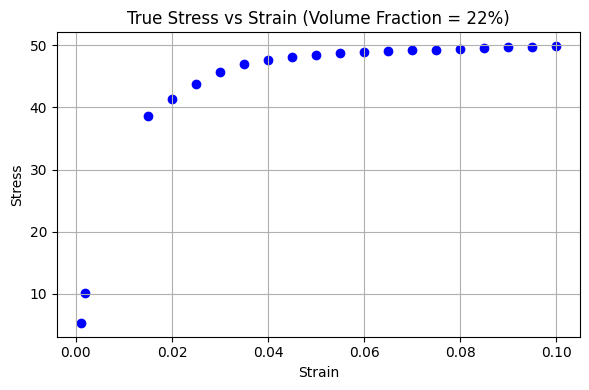

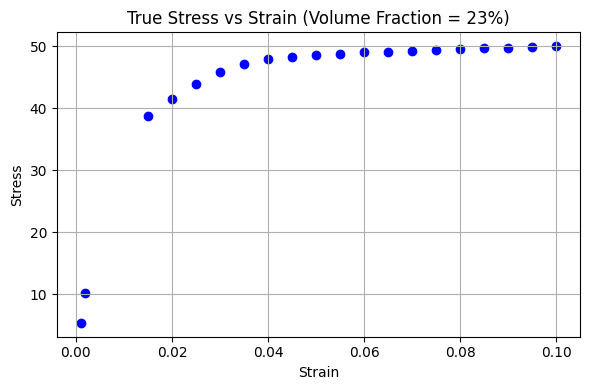

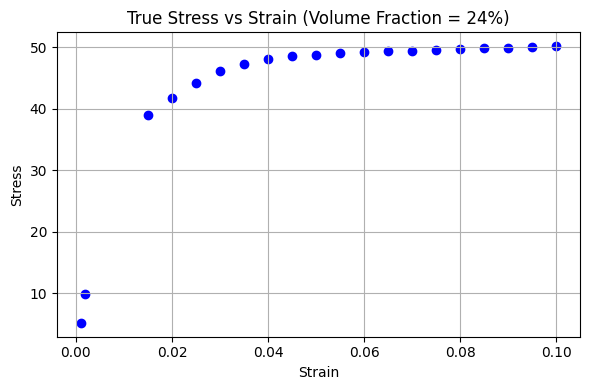

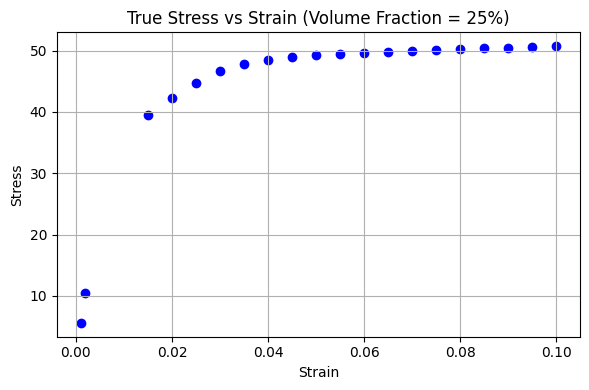

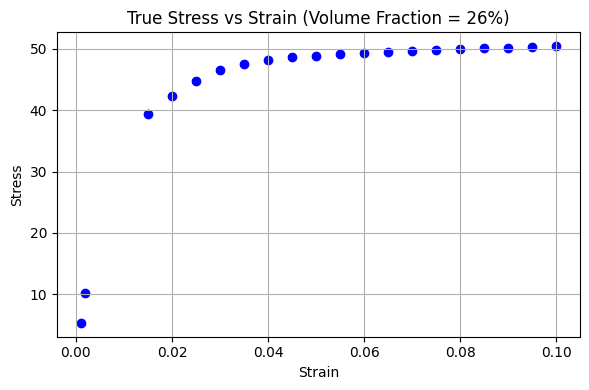

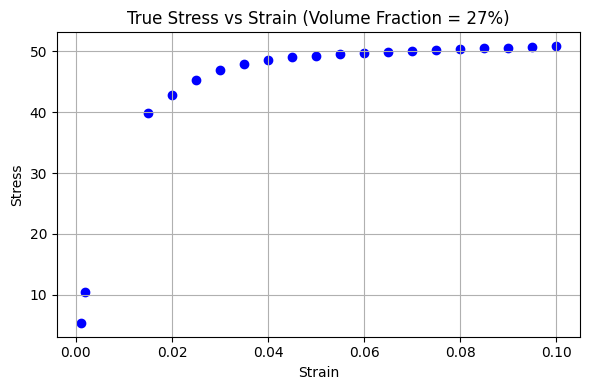

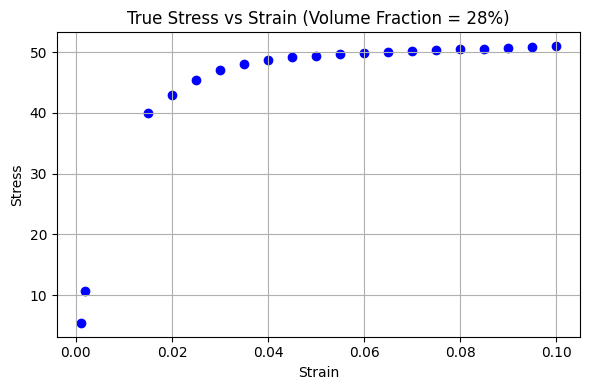

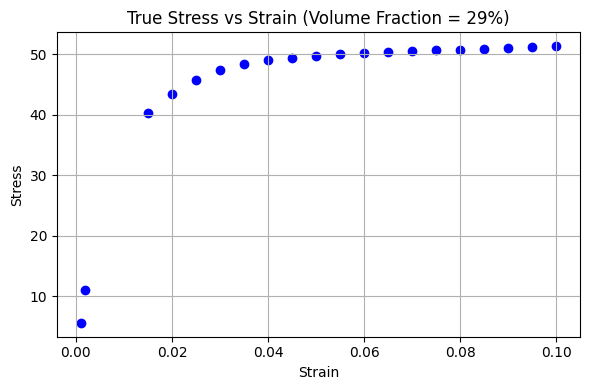

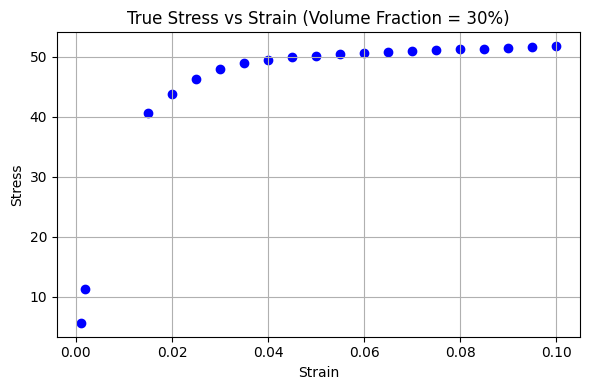

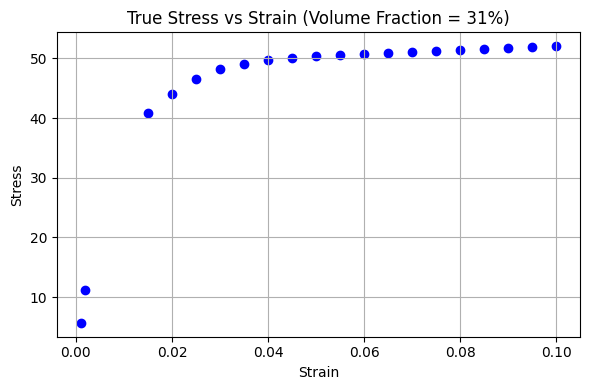

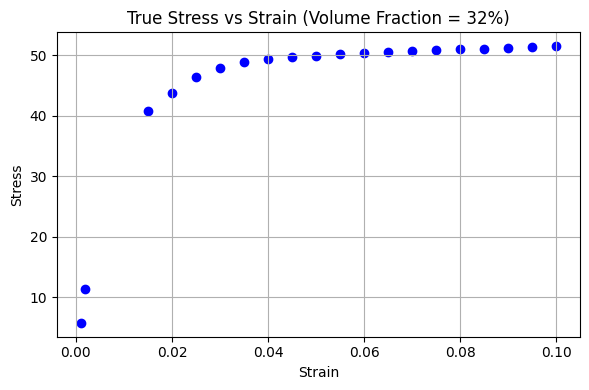

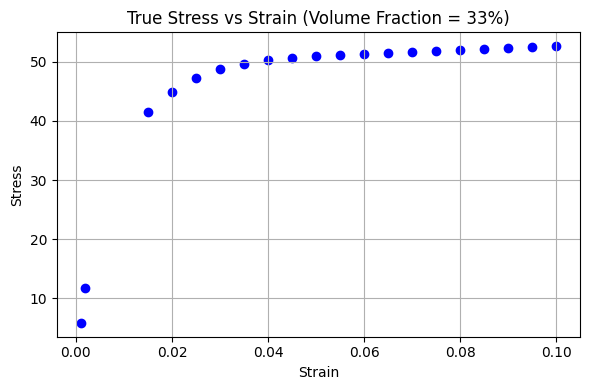

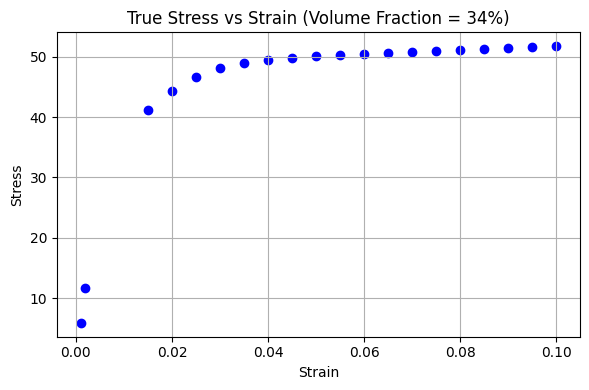

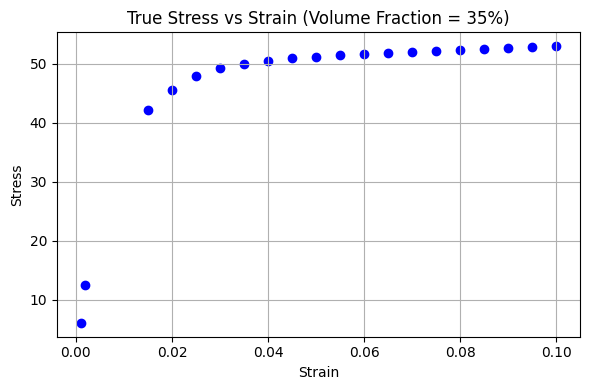

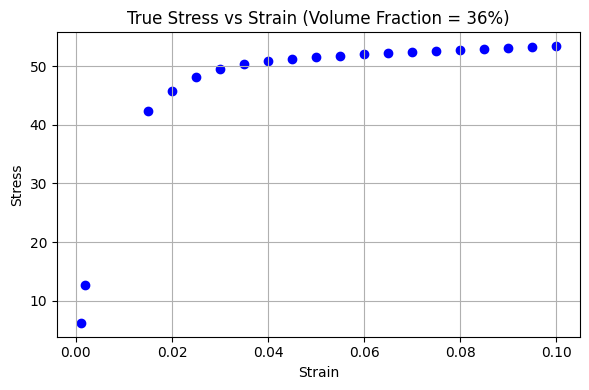

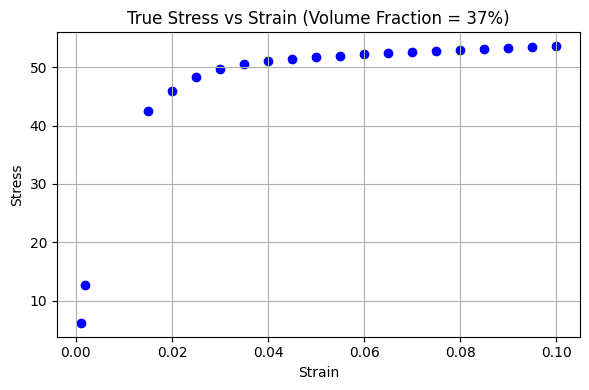

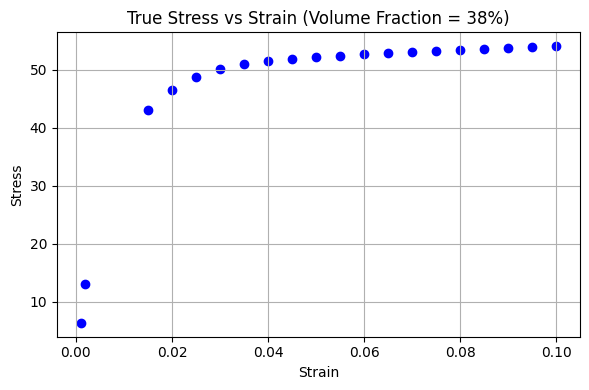

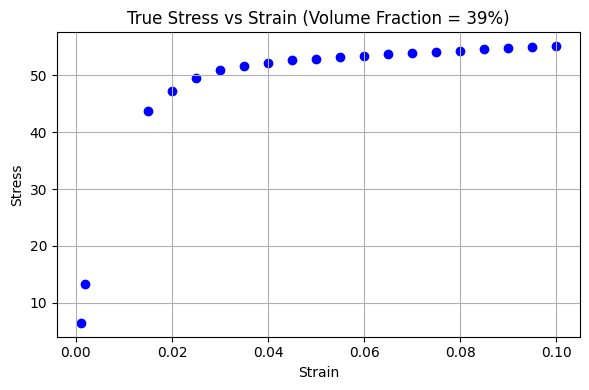

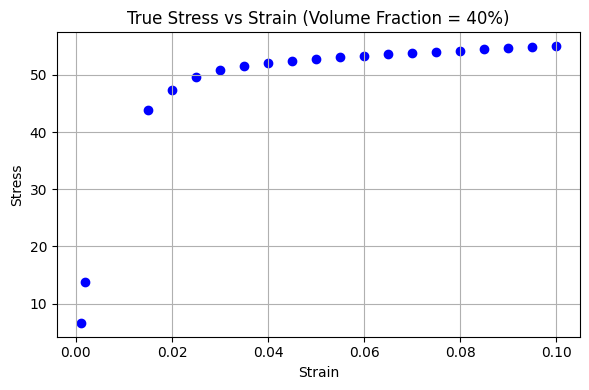

In [ ]:
# Get all unique volume fractions
unique_vf = sorted(df['Volume_Fraction'].unique())

# Plot the true stress–strain curve for each volume fraction
for vf in unique_vf:
    # Filter the DataFrame for the current volume fraction
    group = df[df['Volume_Fraction'] == vf]

    # Extract stress and strain values
    stress = group['Stress'].values
    strain = group['Strain'].values

    # Create the plot
    plt.figure(figsize=(6, 4))
    plt.scatter( strain,stress, label='True Curve', color='blue')
    plt.ylabel("Stress")
    plt.xlabel("Strain")
    plt.title(f"True Stress vs Strain (Volume Fraction = {vf}%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Step 03: Define the RNN Model for Stress Prediction**

In this step, we define a Recurrent Neural Network (RNN) model using PyTorch. The model takes in a sequence of input features — volume fraction and strain — and learns to predict the corresponding stress values.

- The RNN layer processes the sequence of inputs and captures temporal dependencies across the stress–strain curve.
- The output layer maps the RNN’s hidden state at each step to a single predicted stress value.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()

        # RNN layer
        # input_size = 2 because we have 2 features: volume_fraction and strain
        # hidden_size = 32 (number of neurons)
        self.rnn_layer = nn.RNN(
            input_size=2,
            hidden_size=16,
            batch_first=True  # ensures input shape is [batch, sequence, features]
        )

        # Output layer
        # Takes the hidden output from RNN and converts to 1 output: stress
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x, hidden_state=None):
        """
        x: input tensor of shape [batch_size, sequence_length, input_features]
        hidden_state: optional initial hidden state for the RNN

        Returns:
            output: predicted stress values
            hidden_state: final hidden state (useful if continuing sequence)
        """
        rnn_output, hidden_state = self.rnn_layer(x, hidden_state)
        predicted_stress = self.output_layer(rnn_output)  # [batch, seq_len, 1]
        return predicted_stress, hidden_state

## **Step 04: Train the RNN Model**

In this step, we train the RNN to learn the mapping between input sequences — volume fraction and strain — and the corresponding output sequence of stress values. Each volume fraction group is treated as an independent sequence.

We use:
- **Mean Squared Error (MSE)** loss for regression
- **Adam optimizer** for fast and adaptive training
- 100 epochs of training with detailed loss tracking

In [ ]:
# Initialize the model and move it to the selected device (CPU or GPU)
model = RNNModel().to(device)

# Define the loss function: Mean Squared Error (used for regression tasks like stress prediction)
criterion = nn.MSELoss()

# Use Adam optimizer — a widely used, adaptive optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
model.train()
print("Starting RNN training...\n")

# Empty list to store average loss per epoch
loss_history = []

# Training loop for a fixed number of epochs
for epoch in range(100):
    total_loss = 0.0

    # Train using each volume fraction group as a sequence
    for vf in sorted(df['Volume_Fraction'].unique()):
        group = df[df['Volume_Fraction'] == vf]

        if len(group) < 2:
            continue

        # Prepare inputs and targets
        input_features = group[['X1', 'X2']].values
        target_stress = group[['y_scaled']].values

        input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0).to(device)
        target_tensor = torch.tensor(target_stress, dtype=torch.float32).unsqueeze(0).to(device)

        # Forward pass
        predicted, _ = model(input_tensor)
        loss = criterion(predicted, target_tensor)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Save average loss of this epoch
    avg_loss = total_loss / len(df['Volume_Fraction'].unique())
    loss_history.append(avg_loss)

    # Print every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Average Loss: {avg_loss:.6f}")

print("\nTraining complete!")


Starting RNN training...

Epoch 000 | Average Loss: 0.561273
Epoch 010 | Average Loss: 0.002553
Epoch 020 | Average Loss: 0.001533
Epoch 030 | Average Loss: 0.001183
Epoch 040 | Average Loss: 0.001211
Epoch 050 | Average Loss: 0.001251
Epoch 060 | Average Loss: 0.001236
Epoch 070 | Average Loss: 0.001183
Epoch 080 | Average Loss: 0.001119
Epoch 090 | Average Loss: 0.001060

Training complete!


## **Visualize Training Loss**

After training, we plot the average MSE loss per epoch to evaluate how well the model is learning. A decreasing loss curve usually indicates successful learning.

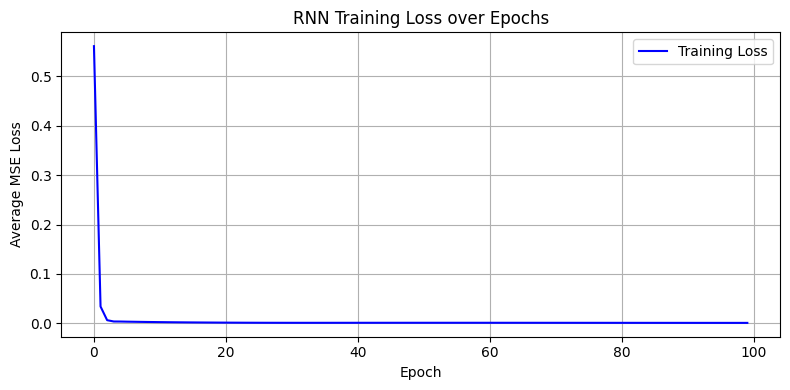

In [ ]:
# Plot training loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title("RNN Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Step 05: Visualize Predicted vs. True Stress–Strain Curves**

Now that the RNN has been trained, we evaluate how well it predicts stress from input features (volume fraction and strain).

For each volume fraction:
- We pass the full stress–strain sequence through the model
- We plot both the true stress values and the predicted ones
- This helps visually assess the model's accuracy for each material configuration

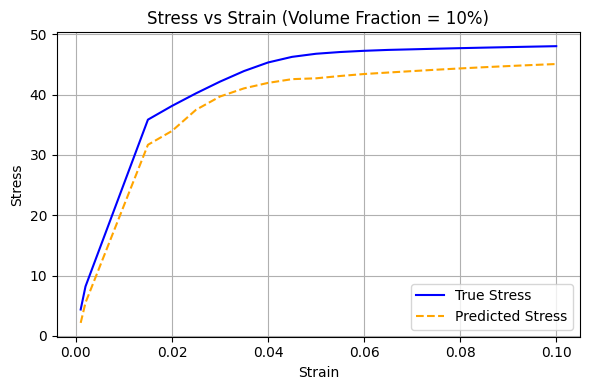

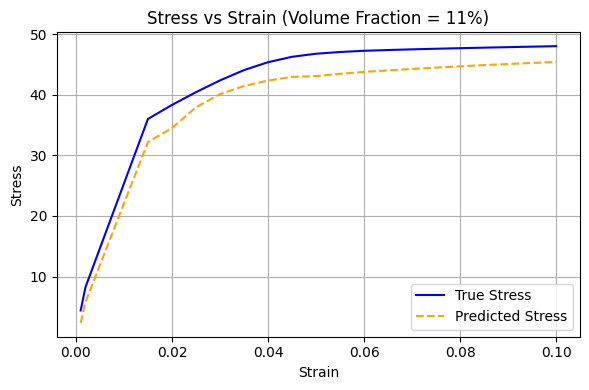

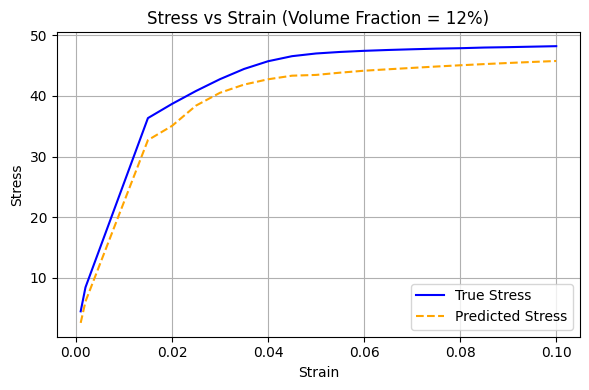

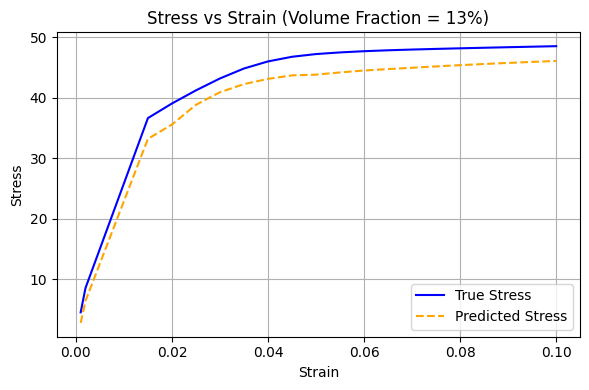

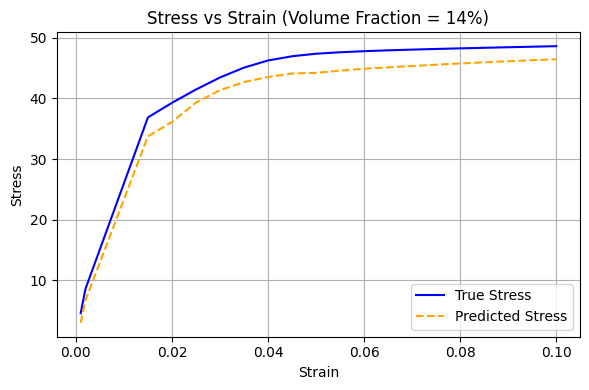

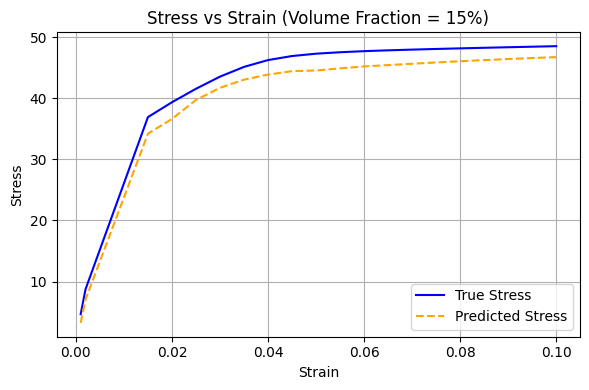

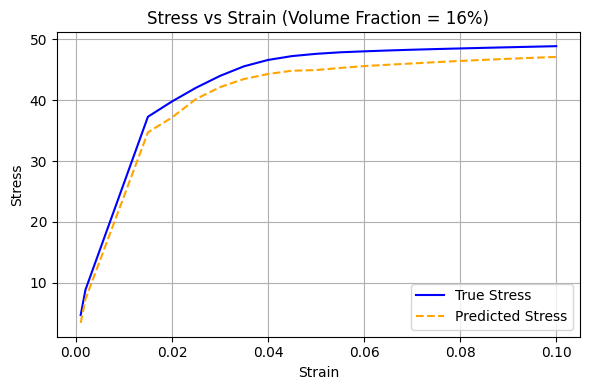

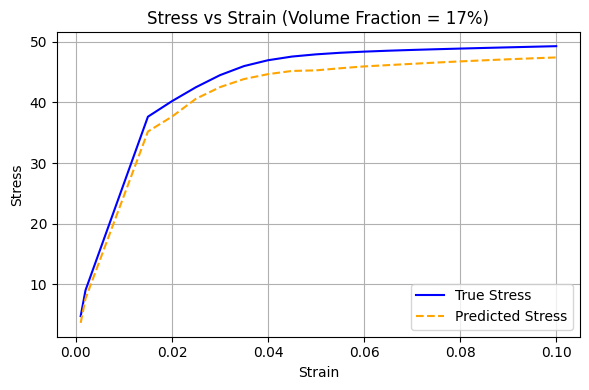

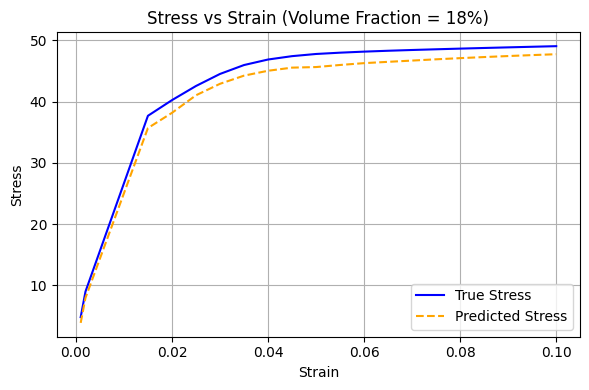

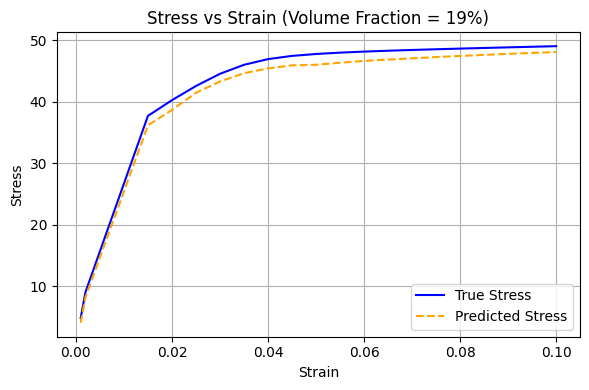

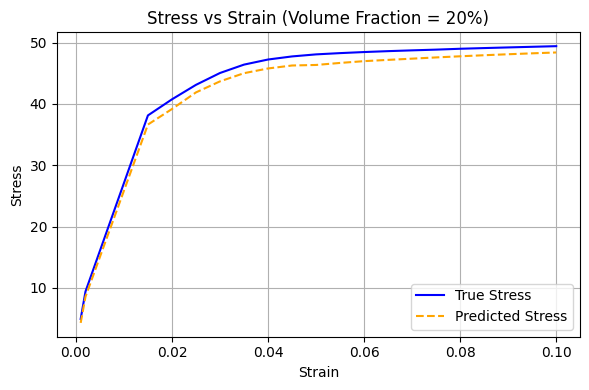

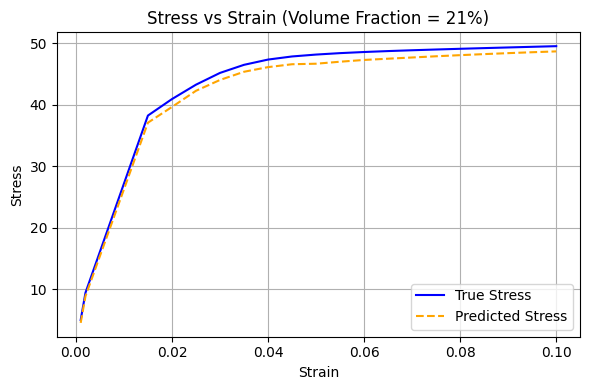

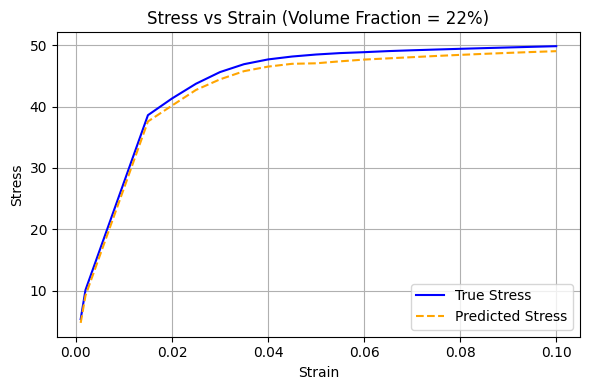

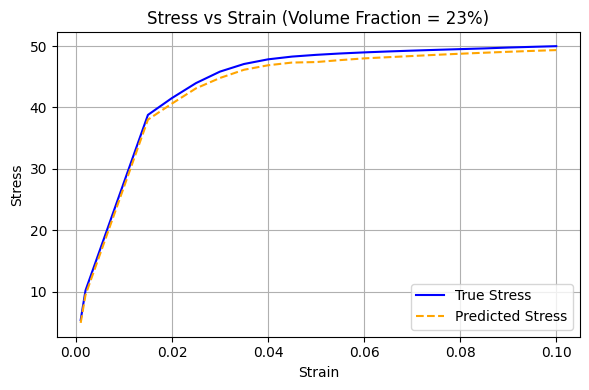

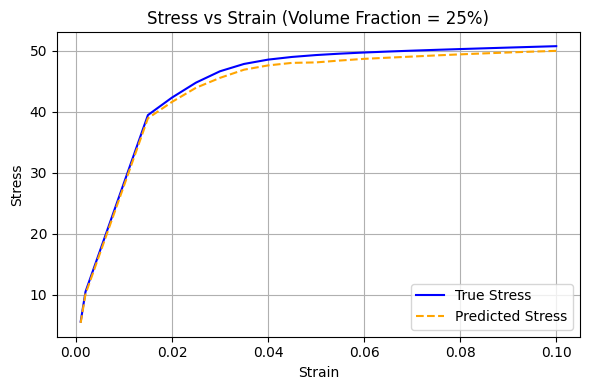

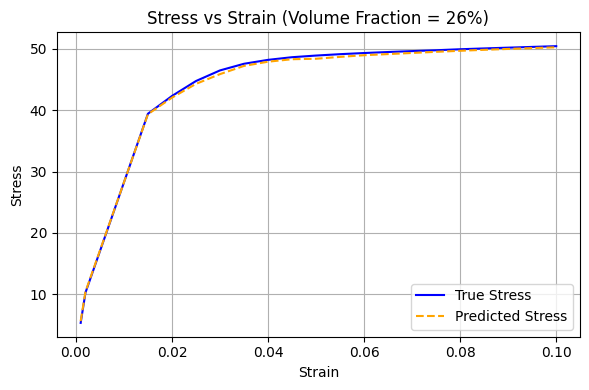

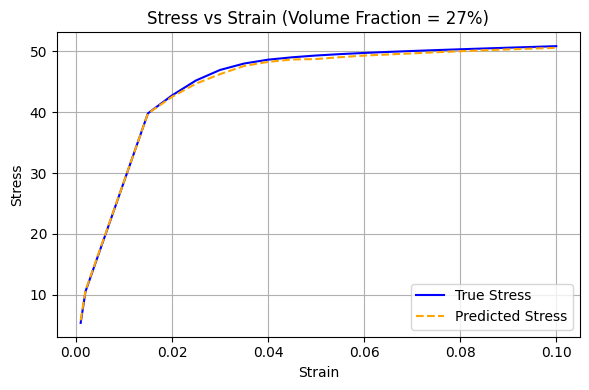

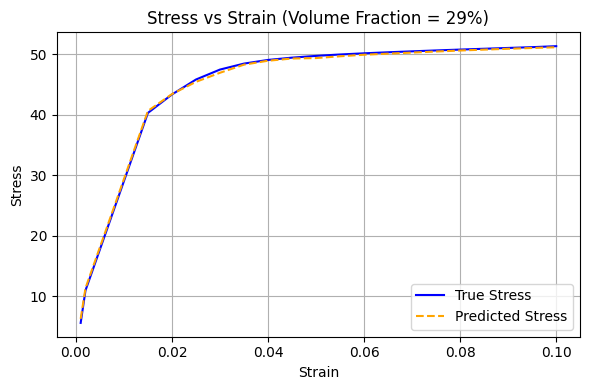

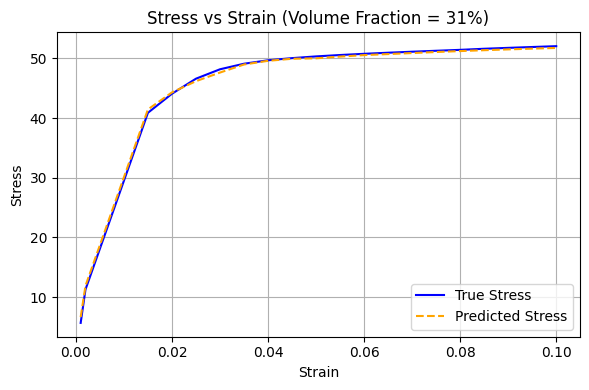

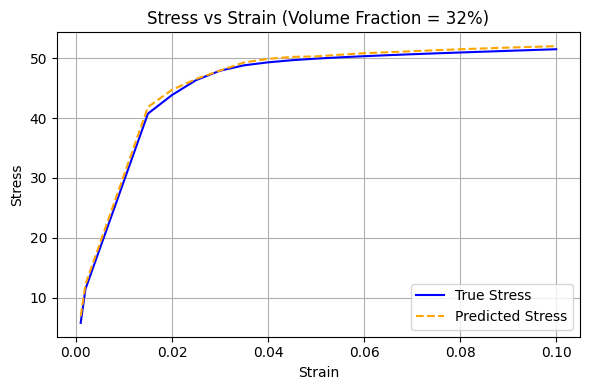

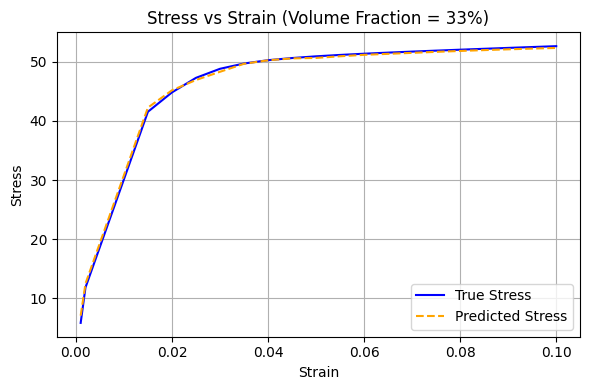

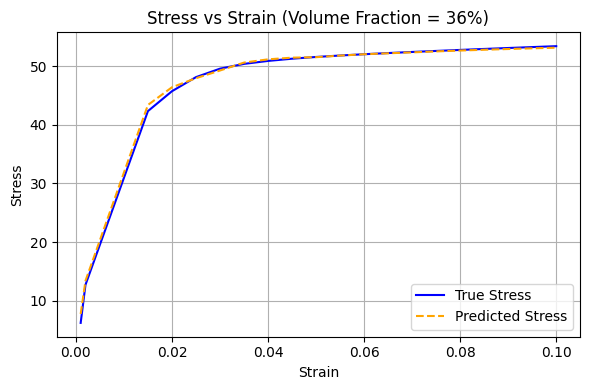

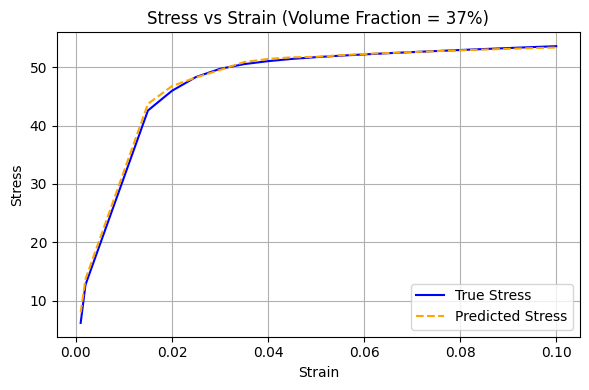

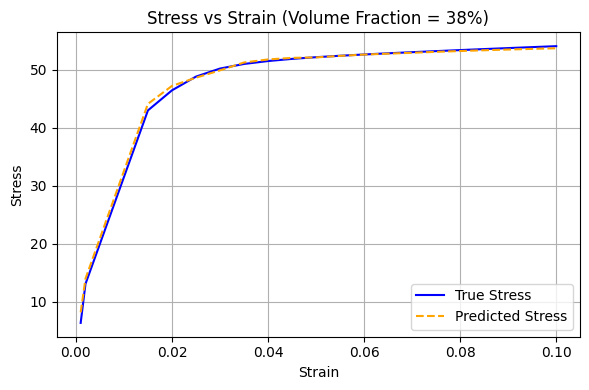

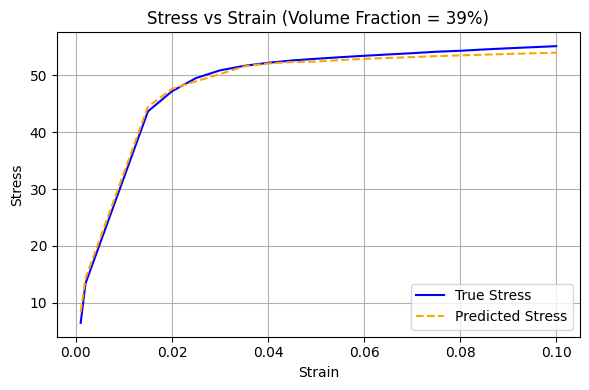

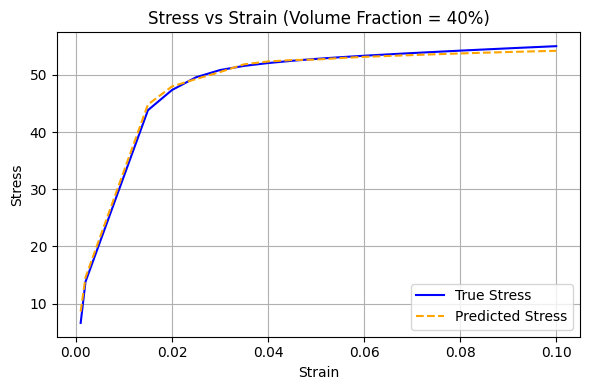

In [ ]:
# Set the model to evaluation mode (no gradients, dropout off)
model.eval()

# Get all unique volume fractions
unique_vf = sorted(df['Volume_Fraction'].unique())

# Loop through each volume fraction group
for vf in unique_vf:
    # Filter the data for the current volume fraction
    group = df[df['Volume_Fraction'] == vf]

    # Extract inputs and true strain
    x_group = group[['X1', 'X2']].values         # Normalized volume fraction and strain
    y_true = group[['Stress']].values            # Actual stress values (not scaled)
    strain = group['Strain'].values              # For x-axis in plot

    # Convert input to tensor and add batch dimension
    x_tensor = torch.tensor(x_group, dtype=torch.float32).unsqueeze(0).to(device)

    # Make predictions with the trained RNN
    with torch.no_grad():
        y_pred_scaled, _ = model(x_tensor)       # Output is still scaled
        y_pred_scaled = y_pred_scaled.squeeze(0).cpu().numpy()

    # Inverse scale the predicted stress to original units
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Plot true vs. predicted stress for this volume fraction
    plt.figure(figsize=(6, 4))
    plt.plot( strain, y_true, label='True Stress', color='blue')
    plt.plot( strain, y_pred, label='Predicted Stress', color='orange', linestyle='--')
    plt.ylabel("Stress")
    plt.xlabel("Strain")
    plt.title(f"Stress vs Strain (Volume Fraction = {vf}%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Evaluate RNN Performance Using Error Metrics**

To quantitatively assess how well the RNN predicts stress, we compute:
- **Mean Squared Error (MSE)** — penalizes larger errors more
- **Mean Absolute Error (MAE)** — gives average absolute error
- **R² Score (Coefficient of Determination)** — measures how well the model explains the variance in true strain

We calculate these metrics separately for each volume fraction to evaluate the model's consistency across different material configurations.

In [ ]:
# Initialize list to store metric results for each volume fraction
metrics = []

# Loop through each volume fraction group
for vf in unique_vf:
    # Extract input and true output for this group
    group = df[df['Volume_Fraction'] == vf]
    x_group = group[['X1', 'X2']].values        # Normalized inputs
    y_true = group[['Stress']].values           # Ground truth stress (original scale)

    # Convert to tensor and add batch dimension
    x_tensor = torch.tensor(x_group, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict using the trained model
    with torch.no_grad():
        y_pred_scaled, _ = model(x_tensor)
        y_pred_scaled = y_pred_scaled.squeeze(0).cpu().numpy()

    # Inverse scale predicted strain back to original values
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Compute error metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Append results
    metrics.append([vf, mse, mae, r2])

# Create DataFrame to organize results
metrics_df = pd.DataFrame(metrics, columns=['Volume_Fraction', 'MSE', 'MAE', 'R2_Score'])

# Display sorted by volume fraction
print("\nRNN Error Metrics by Volume Fraction:")
print(metrics_df.sort_values("Volume_Fraction"))


RNN Error Metrics by Volume Fraction:
    Volume_Fraction        MSE       MAE  R2_Score
0                10  11.489856  3.343315  0.922851
1                11   9.341377  3.014311  0.937026
2                12   8.484848  2.872842  0.943001
3                13   8.027574  2.796256  0.946623
4                14   6.618211  2.536505  0.956022
5                15   4.923134  2.186299  0.967123
6                16   4.631217  2.120375  0.969315
7                17   4.669226  2.128058  0.969489
8                18   2.815241  1.647082  0.981421
9                19   1.734134  1.288504  0.988502
10               20   1.750524  1.297524  0.988471
11               21   1.229458  1.080549  0.991943
12               22   1.158915  1.060123  0.992327
13               23   0.743503  0.845901  0.995079
14               24   0.531477  0.685383  0.996556
15               25   0.771657  0.845160  0.995016
16               26   0.109503  0.306483  0.999290
17               27   0.153536  0.364231  0

### **Why Are We Using a Feedforward Neural Network (FFNN)?**

While Recurrent Neural Networks (RNNs) are designed to handle **sequential data**, we also want to test a simpler, non-sequential baseline: the **Feedforward Neural Network (FFNN)**.

The FFNN assumes that each (volume fraction, strain) → stress data point is **independent**, without relying on the order or structure of the sequence. This helps us answer:

> **Does modeling the stress–strain data as a sequence (via RNN) really improve prediction accuracy?**

By comparing the FFNN and RNN results side by side — especially using metrics like **R² score** — we can understand whether the added complexity of an RNN is justified.

In [ ]:
class FFNNModel(nn.Module):
    def __init__(self):
        super(FFNNModel, self).__init__()

        # Define the FFNN architecture using nn.Sequential
        self.network = nn.Sequential(
            nn.Linear(2, 64),   # First hidden layer: input is 2 features (volume_fraction, strain)
            nn.ReLU(),          # Non-linear activation
            nn.Linear(64, 64),  # Second hidden layer with 64 neurons
            nn.ReLU(),          # Another ReLU for non-linearity
            nn.Linear(64, 1)    # Output layer: predict stress (1 value)
        )

    def forward(self, x):
        # Forward pass: pass input through the network
        return self.network(x)

In [ ]:
# Use the same scaled X and y from earlier
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)  # shape: [N, 2]
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).to(device)  # shape: [N, 1]

Starting FFNN training...

Epoch 000 | Loss: 0.876534
Epoch 010 | Loss: 0.521878
Epoch 020 | Loss: 0.265559
Epoch 030 | Loss: 0.088702
Epoch 040 | Loss: 0.039077
Epoch 050 | Loss: 0.045644
Epoch 060 | Loss: 0.034965
Epoch 070 | Loss: 0.032947
Epoch 080 | Loss: 0.030743
Epoch 090 | Loss: 0.028465

FFNN training complete!


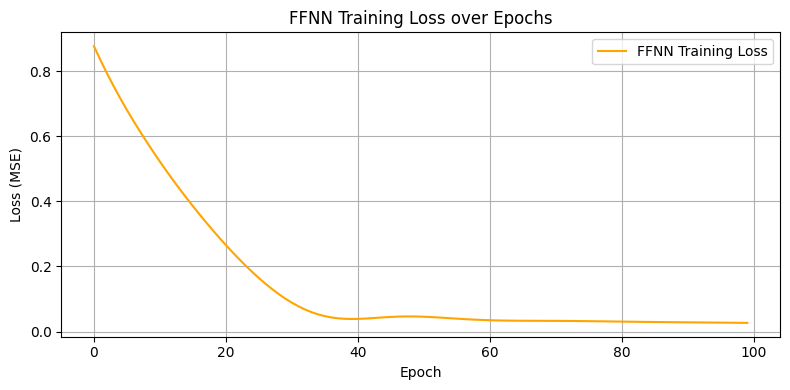

In [ ]:
# Initialize model, loss, optimizer
ffnn = FFNNModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnn.parameters(), lr=0.001)

# Store loss values
ffnn_loss_history = []

# Training loop
print("Starting FFNN training...\n")
ffnn.train()
for epoch in range(100):
    optimizer.zero_grad()
    pred = ffnn(X_tensor)
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()

    # Save loss
    ffnn_loss_history.append(loss.item())

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.6f}")

print("\nFFNN training complete!")

# Plot FFNN loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(ffnn_loss_history, label="FFNN Training Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("FFNN Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

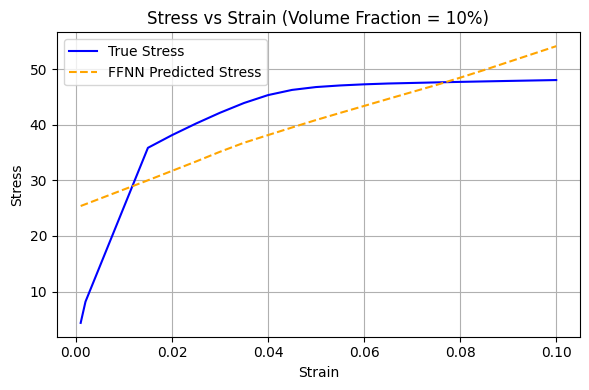

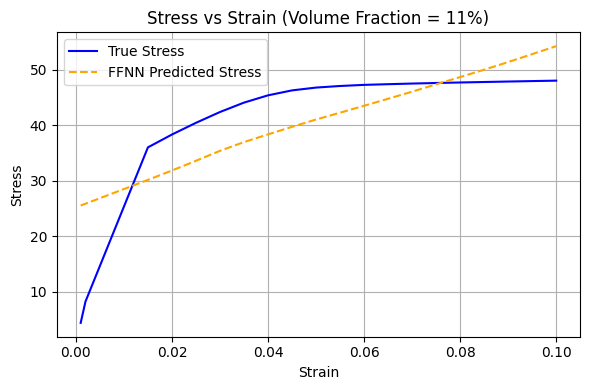

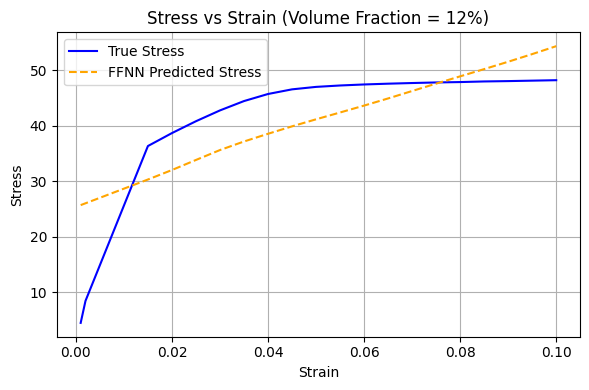

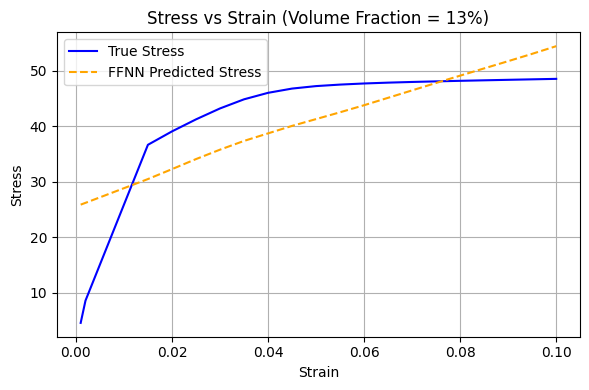

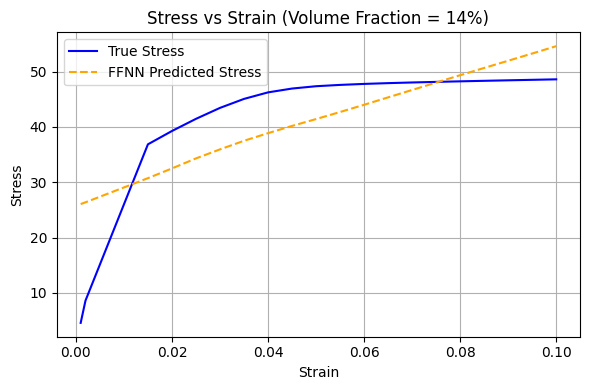

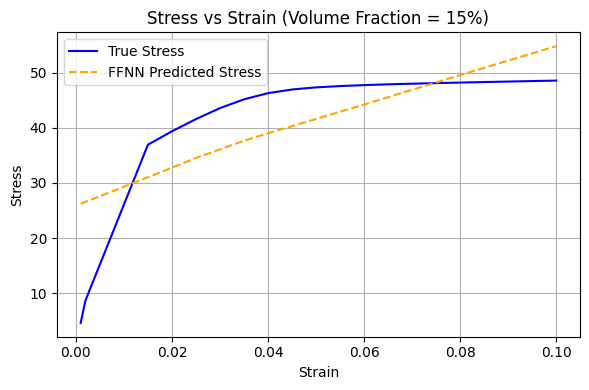

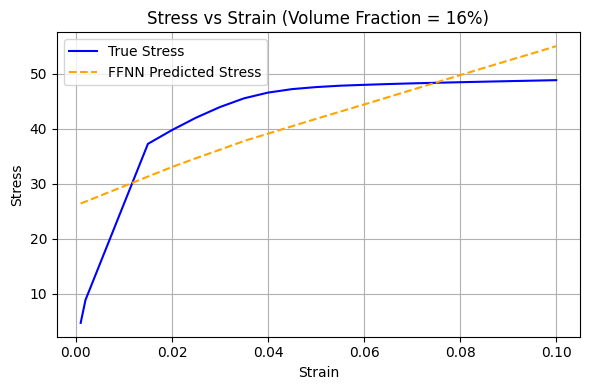

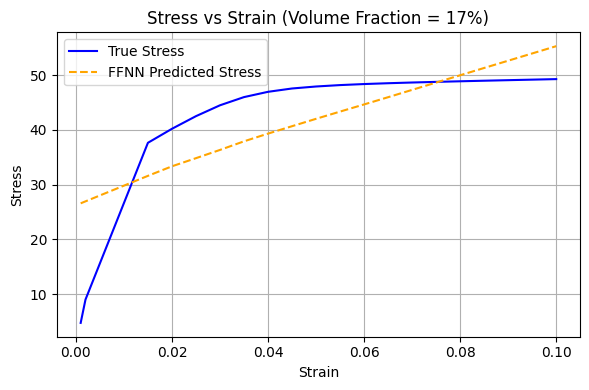

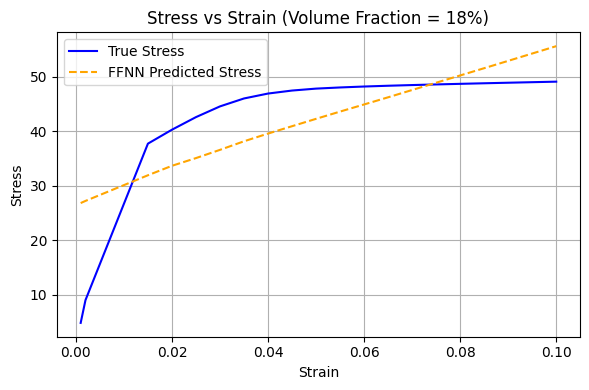

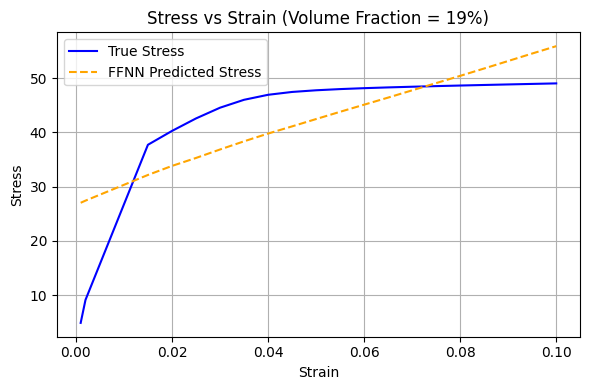

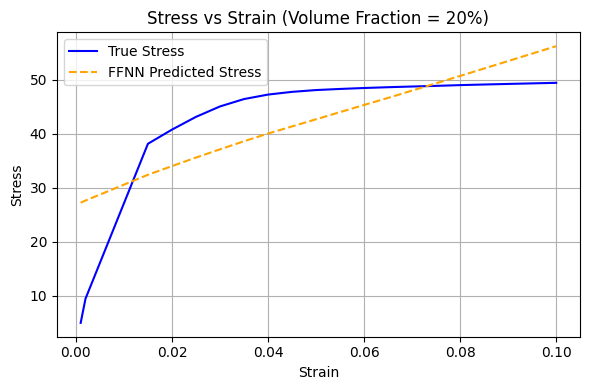

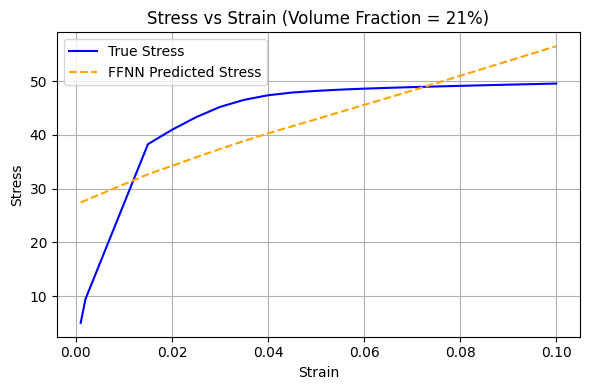

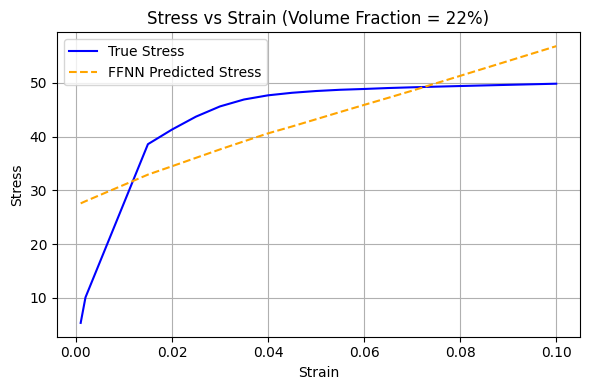

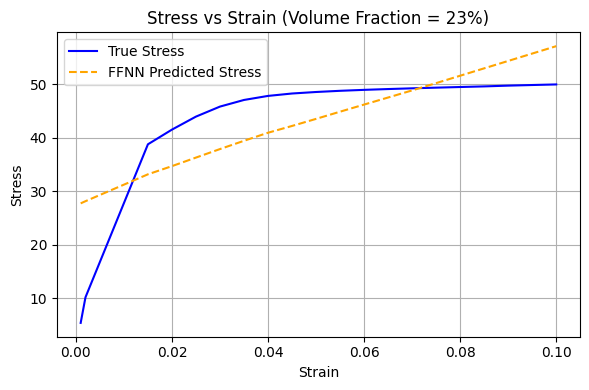

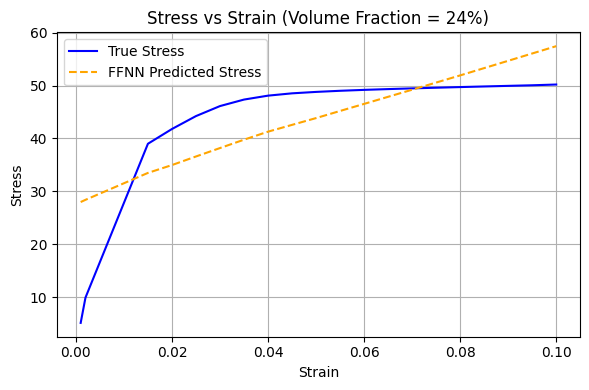

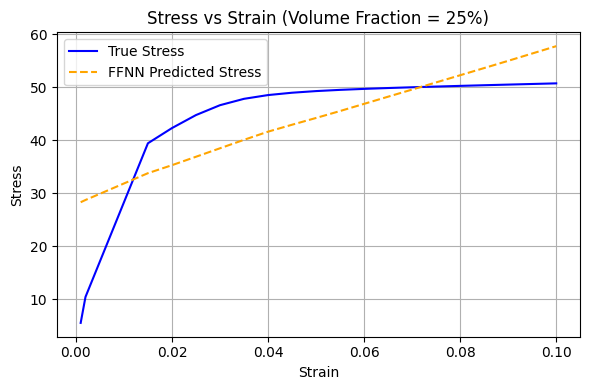

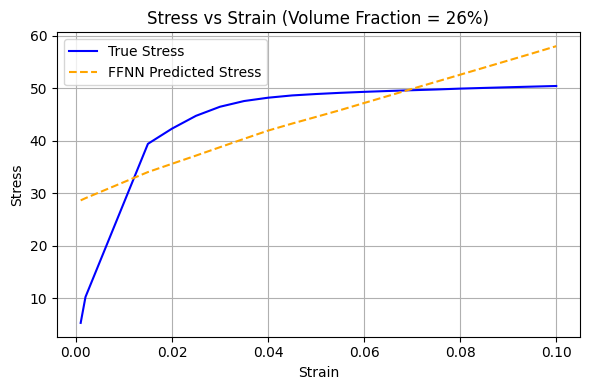

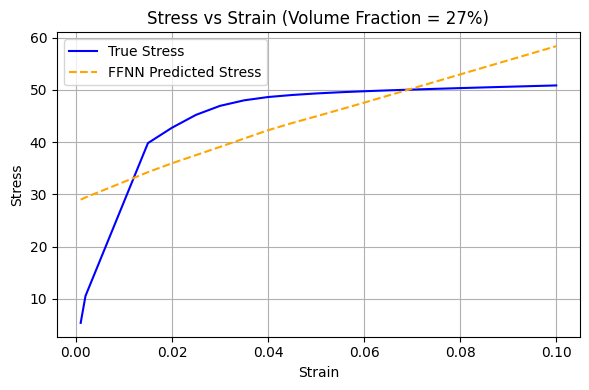

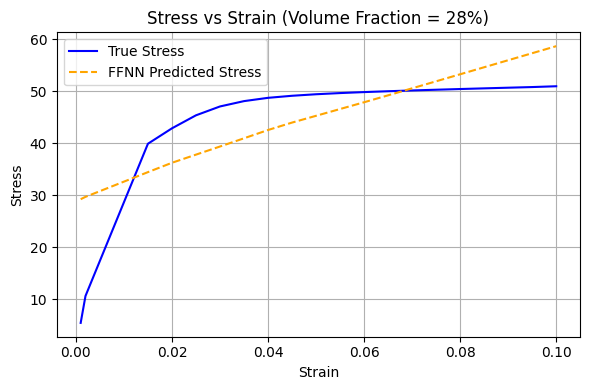

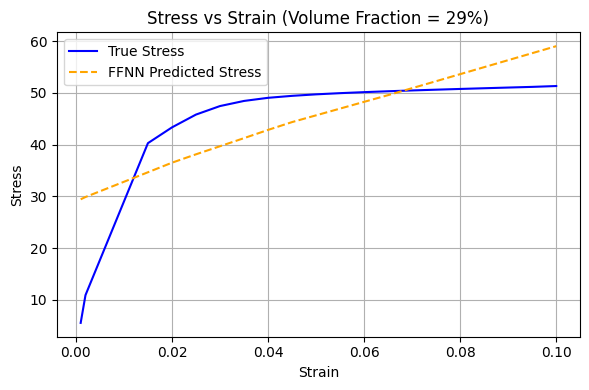

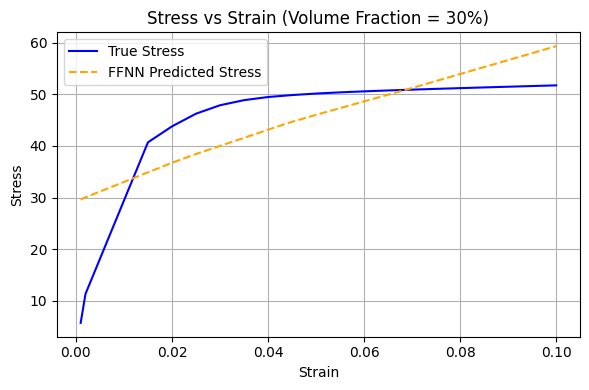

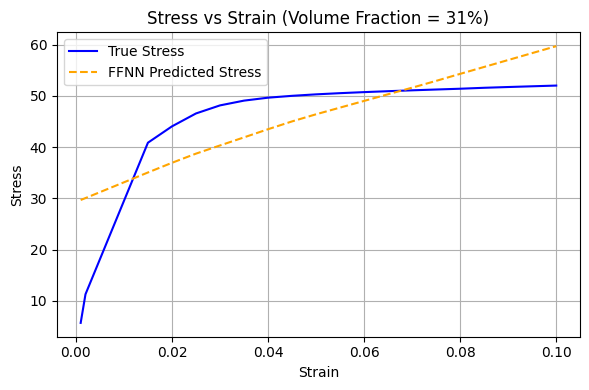

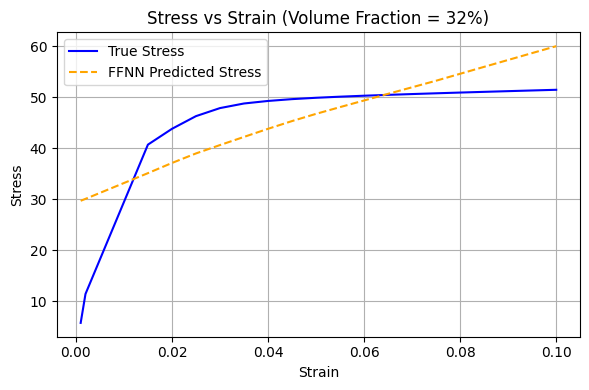

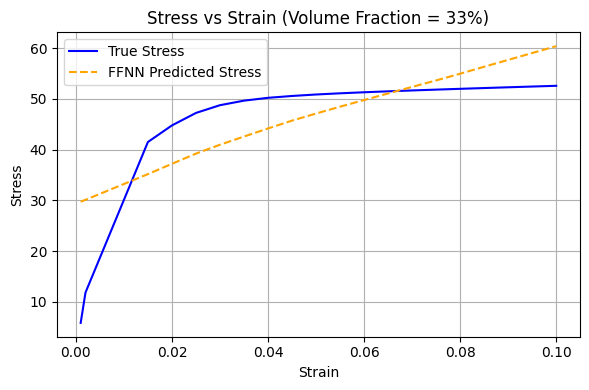

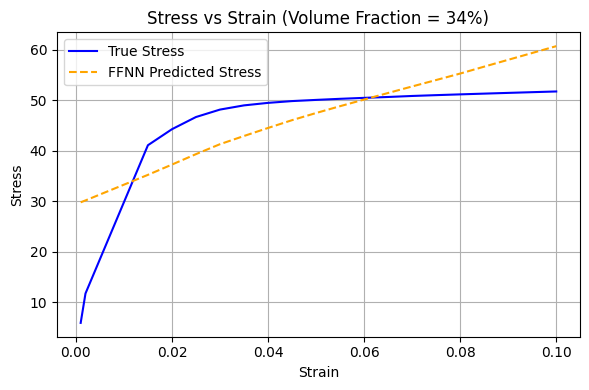

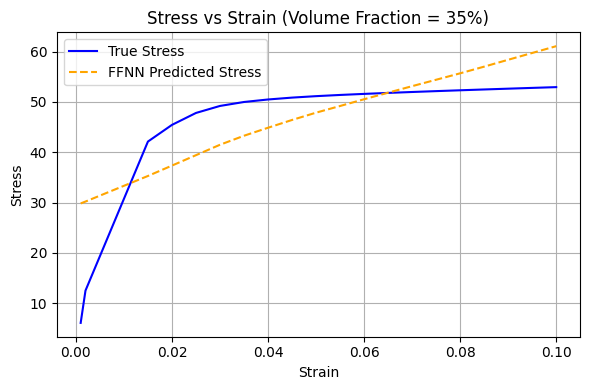

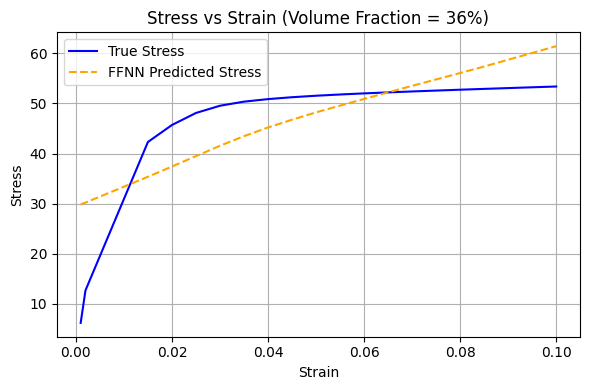

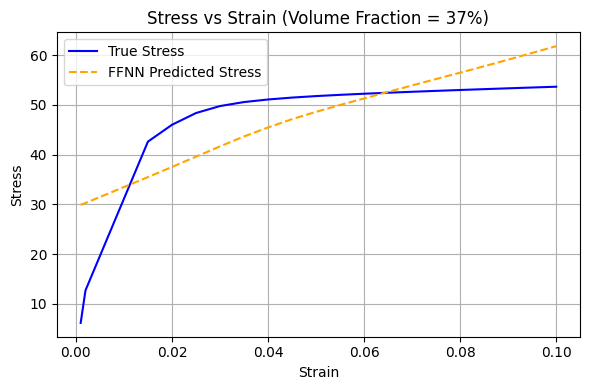

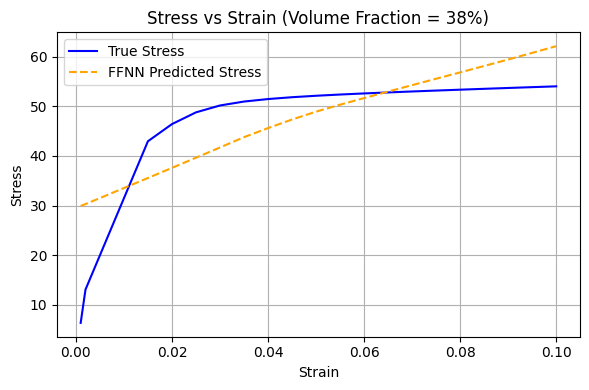

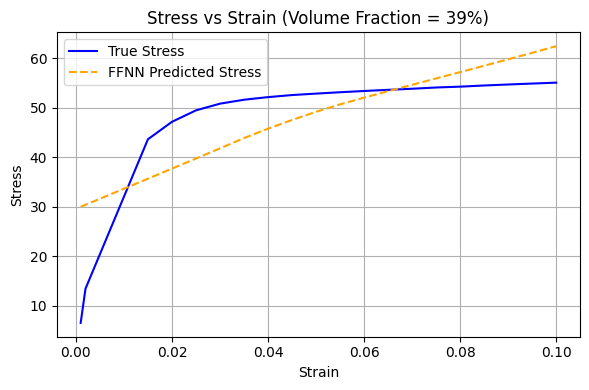

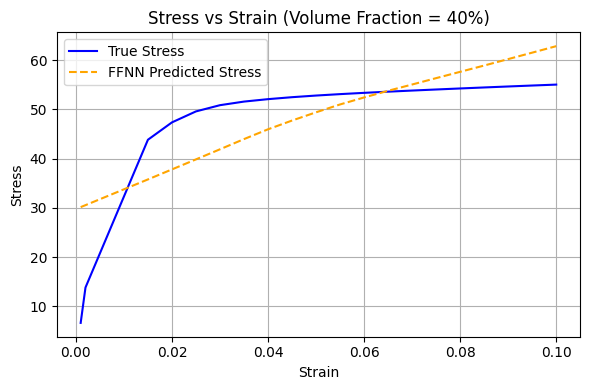

In [ ]:
# Grouped plot: Stress vs Strain for each volume fraction
unique_vf = sorted(df['Volume_Fraction'].unique())

ffnn.eval()
for vf in unique_vf:
    group = df[df['Volume_Fraction'] == vf]

    # Get normalized input
    X_group = scaler_x.transform(group[['Volume_Fraction', 'Strain']].values)
    y_true = group[['Stress']].values
    strain = group['Strain'].values

    X_tensor = torch.tensor(X_group, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_scaled = ffnn(X_tensor).cpu().numpy()

    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Plot stress vs strain
    plt.figure(figsize=(6, 4))
    plt.plot(strain, y_true, label='True Stress', color='blue')
    plt.plot( strain, y_pred, label='FFNN Predicted Stress', color='orange', linestyle='--')
    plt.ylabel("Stress")
    plt.xlabel("Strain")
    plt.title(f"Stress vs Strain (Volume Fraction = {vf}%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
metrics_ffnn = []

for vf in sorted(df['Volume_Fraction'].unique()):
    group = df[df['Volume_Fraction'] == vf]

    # Get normalized input
    X_group = scaler_x.transform(group[['Volume_Fraction', 'Strain']].values)
    y_true = group[['Stress']].values

    X_tensor = torch.tensor(X_group, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_scaled = ffnn(X_tensor).cpu().numpy()

    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics_ffnn.append([vf, mse, mae, r2])

# Display results
metrics_ffnn_df = pd.DataFrame(metrics_ffnn, columns=["Volume_Fraction", "MSE", "MAE", "R2_Score"])
print("\nFFNN Error Metrics by Volume Fraction:")
print(metrics_ffnn_df.sort_values("Volume_Fraction"))


FFNN Error Metrics by Volume Fraction:
    Volume_Fraction        MSE       MAE  R2_Score
0                10  61.454446  6.118981  0.587361
1                11  61.498049  6.097232  0.585418
2                12  62.406105  6.158320  0.580773
3                13  63.473189  6.219814  0.577953
4                14  64.177875  6.240568  0.573534
5                15  64.223405  6.220213  0.571113
6                16  65.414442  6.286696  0.566580
7                17  66.829750  6.366703  0.563306
8                18  66.667832  6.326475  0.560021
9                19  66.521719  6.295489  0.558936
10               20  67.445846  6.359928  0.555819
11               21  67.742211  6.354555  0.556067
12               22  66.892086  6.350810  0.557105
13               23  66.853927  6.324635  0.557476
14               24  68.718037  6.358604  0.554713
15               25  68.612546  6.372661  0.556851
16               26  69.642892  6.317171  0.548570
17               27  70.657406  6.358167  

### **R² Score Comparison: RNN vs FFNN**

To evaluate which model performs better at predicting stress from strain and volume fraction, we compare the **R² scores** (coefficient of determination) for each model across all volume fractions.

- **RNN** captures sequence dependencies within each stress–strain curve (treated as a time series).
- **FFNN** treats each (volume fraction, strain) input as independent, without considering sequential structure.

By plotting the R² scores side-by-side for each volume fraction, we can visually assess:
- Which model generalizes better?
- Does sequence modeling via RNN lead to better accuracy?

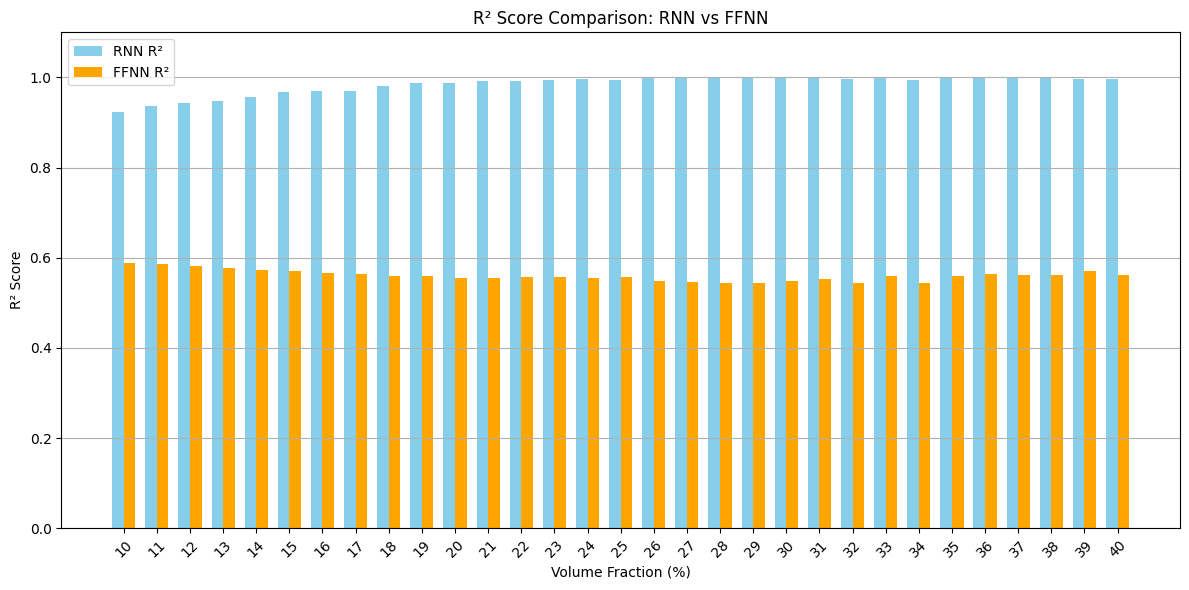

In [ ]:
# Ensure both are sorted by Volume_Fraction
metrics_rnn_sorted = metrics_df.sort_values("Volume_Fraction").reset_index(drop=True)
metrics_ffnn_sorted = metrics_ffnn_df.sort_values("Volume_Fraction").reset_index(drop=True)

# Merge the two R² columns into one DataFrame
r2_comparison = pd.DataFrame({
    "Volume_Fraction": metrics_rnn_sorted["Volume_Fraction"],
    "RNN_R2": metrics_rnn_sorted["R2_Score"],
    "FFNN_R2": metrics_ffnn_sorted["R2_Score"]
})

import matplotlib.pyplot as plt
import numpy as np

volume_fractions = r2_comparison["Volume_Fraction"]
r2_rnn = r2_comparison["RNN_R2"]
r2_ffnn = r2_comparison["FFNN_R2"]

x = np.arange(len(volume_fractions))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_rnn, width, label='RNN R²', color='skyblue')
plt.bar(x + width/2, r2_ffnn, width, label='FFNN R²', color='orange')

plt.xlabel("Volume Fraction (%)")
plt.ylabel("R² Score")
plt.title("R² Score Comparison: RNN vs FFNN")
plt.xticks(ticks=x, labels=volume_fractions.astype(int), rotation=45)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## **LSTM Model**

In [ ]:
import torch
import torch.nn as nn

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm_layer = nn.LSTM(
            input_size=2,
            hidden_size=32,
            batch_first=True
        )
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x, hidden_state=None):
        lstm_output, hidden_state = self.lstm_layer(x, hidden_state)
        predicted_stress = self.output_layer(lstm_output)
        return predicted_stress, hidden_state

# Now this will work
model = LSTMModel().to(device)


In [ ]:
# Define the loss function: Mean Squared Error (used for regression tasks like strain prediction)
criterion = nn.MSELoss()

# Use Adam optimizer — a widely used, adaptive optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
model.train()
print("Starting LSTM training...\n")

# Empty list to store average loss per epoch
loss_history = []

# Training loop for a fixed number of epochs
for epoch in range(500):
    total_loss = 0.0

    # Train using each volume fraction group as a sequence
    for vf in sorted(df['Volume_Fraction'].unique()):
        group = df[df['Volume_Fraction'] == vf]

        if len(group) < 2:
            continue

        # Prepare inputs and targets
        input_features = group[['X1', 'X2']].values
        target_stress = group[['y_scaled']].values

        input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0).to(device)
        target_tensor = torch.tensor(target_stress, dtype=torch.float32).unsqueeze(0).to(device)

        # Forward pass
        predicted, _ = model(input_tensor)
        loss = criterion(predicted, target_tensor)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Save average loss of this epoch
    avg_loss = total_loss / len(df['Volume_Fraction'].unique())
    loss_history.append(avg_loss)

    # Print every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch:03d} | Average Loss: {avg_loss:.6f}")

print("\nTraining complete!")

Starting LSTM training...

Epoch 000 | Average Loss: 0.353748
Epoch 100 | Average Loss: 0.000054
Epoch 200 | Average Loss: 0.000071
Epoch 300 | Average Loss: 0.000300
Epoch 400 | Average Loss: 0.000030

Training complete!


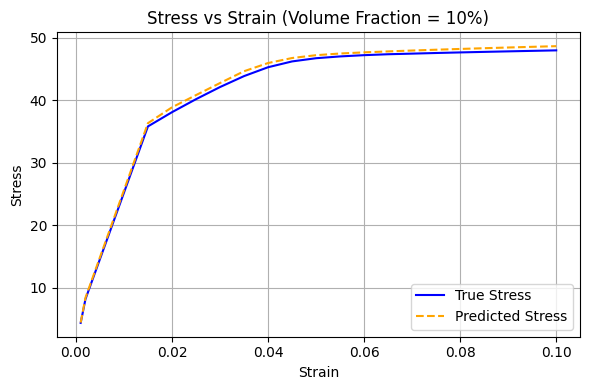

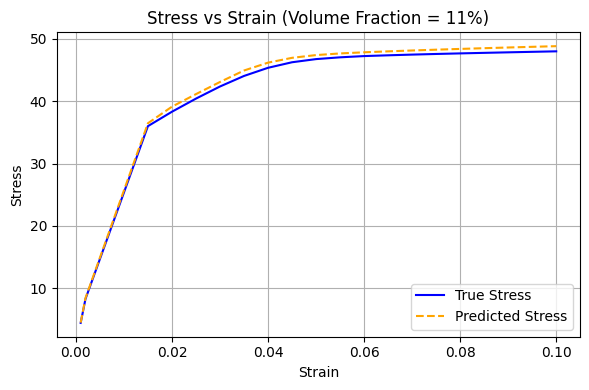

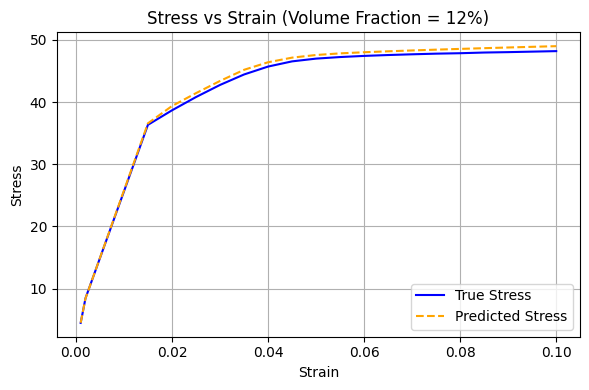

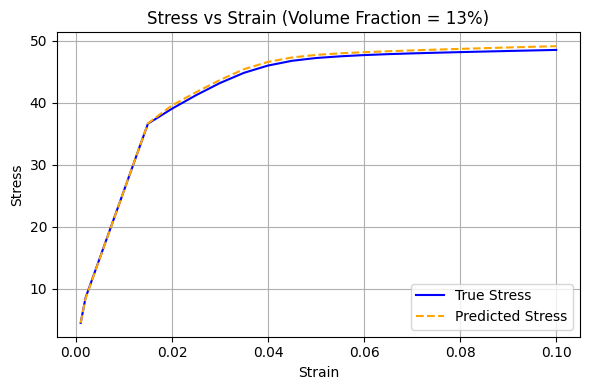

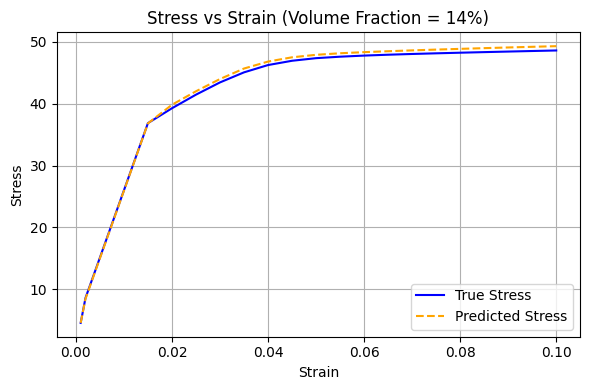

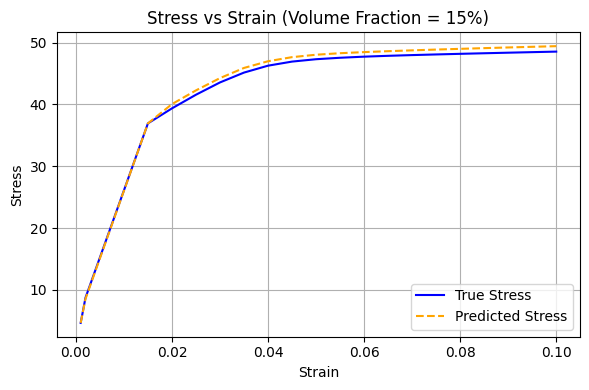

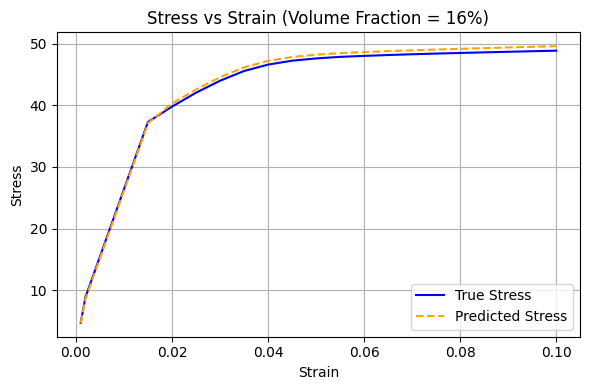

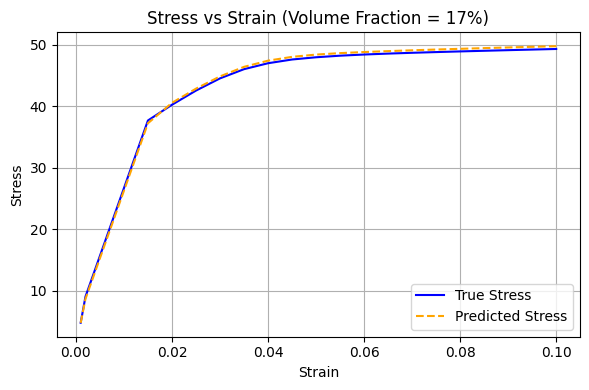

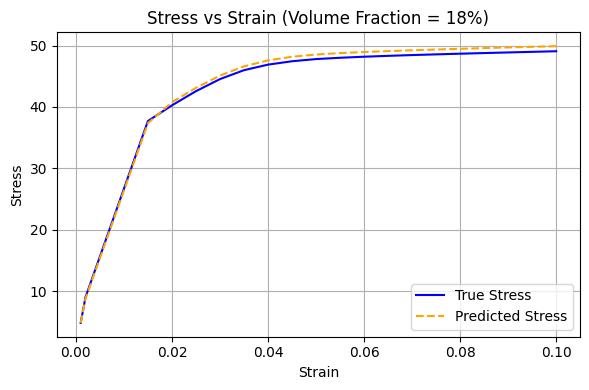

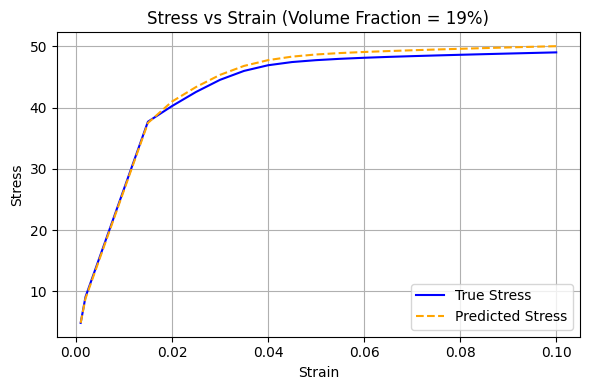

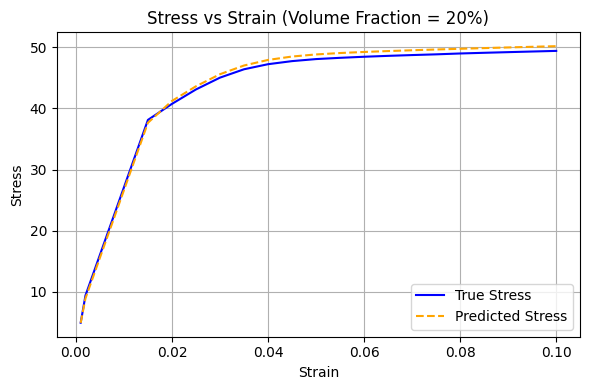

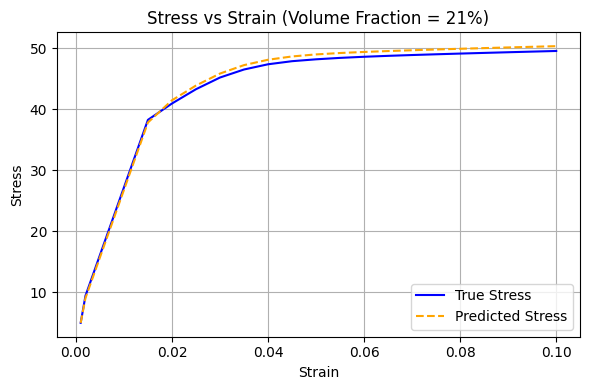

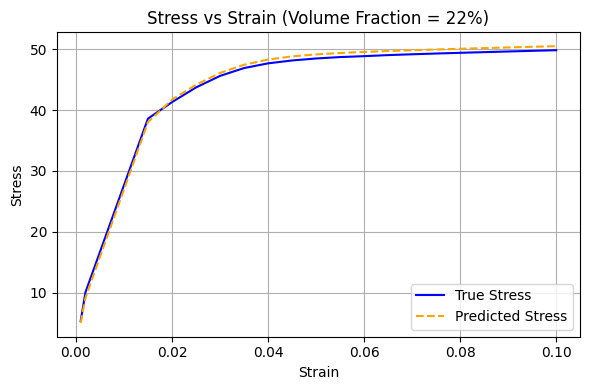

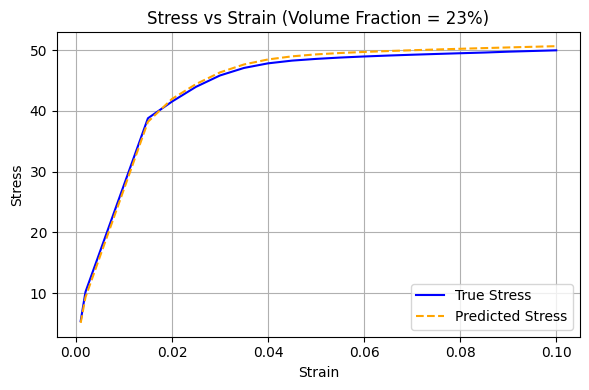

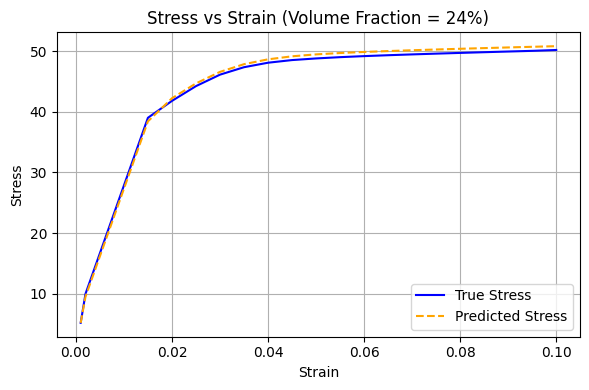

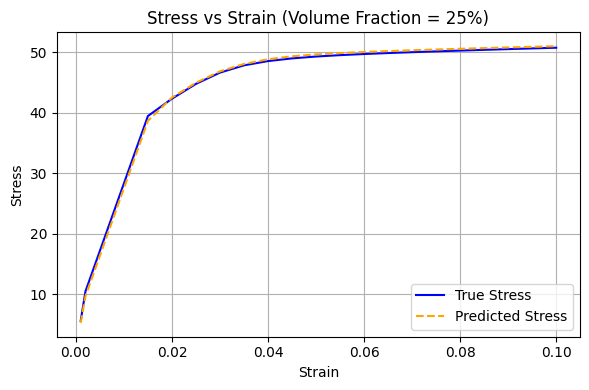

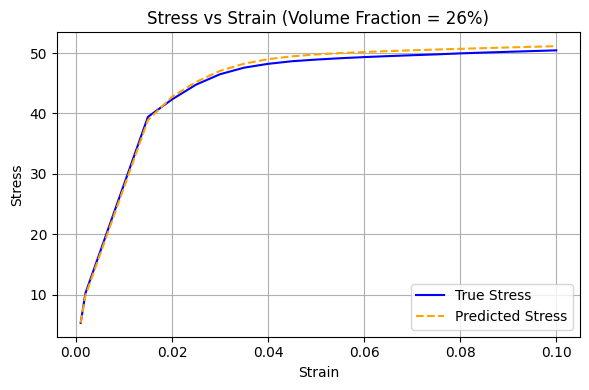

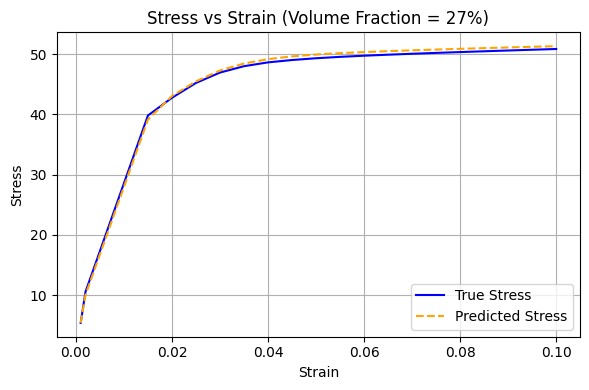

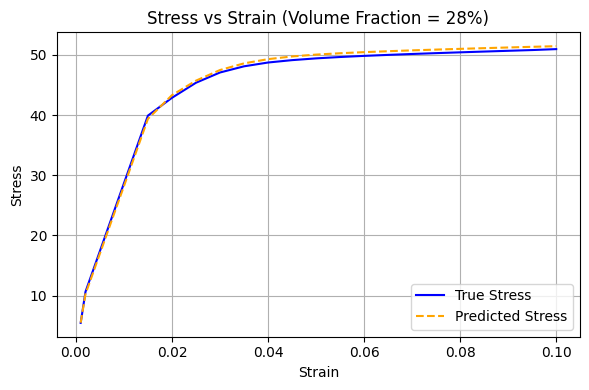

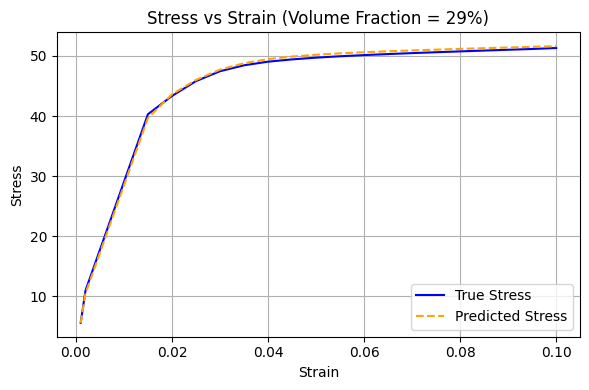

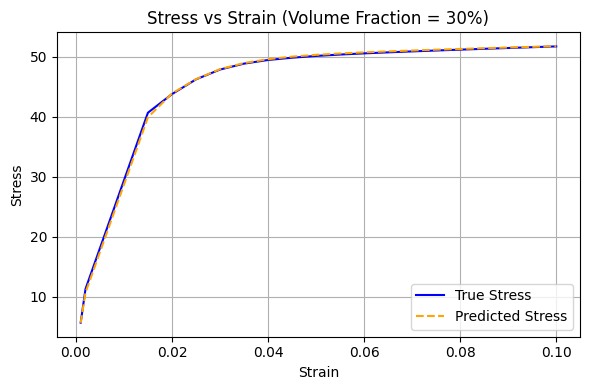

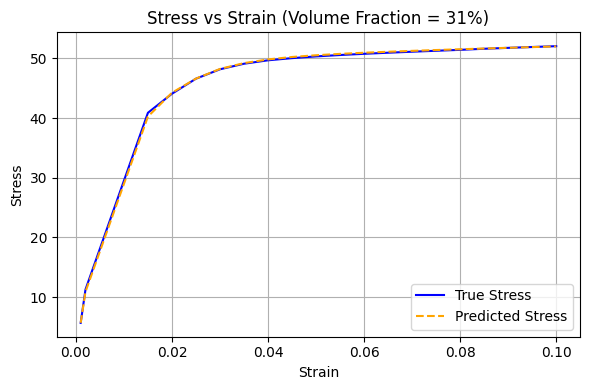

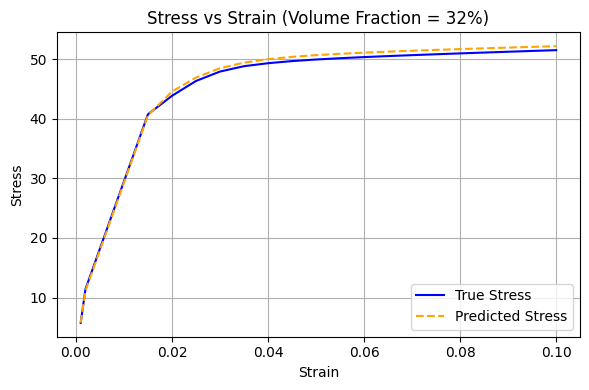

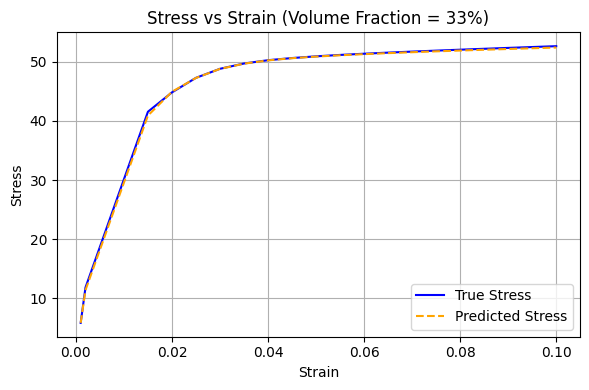

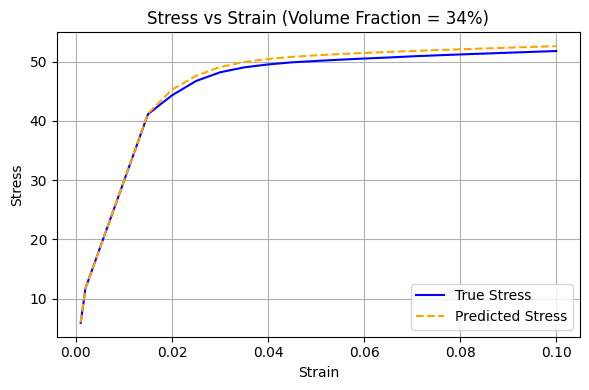

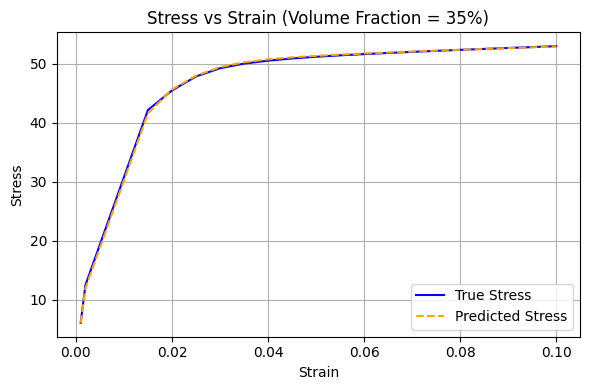

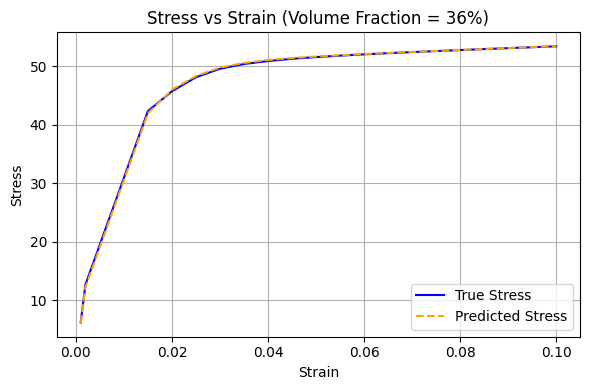

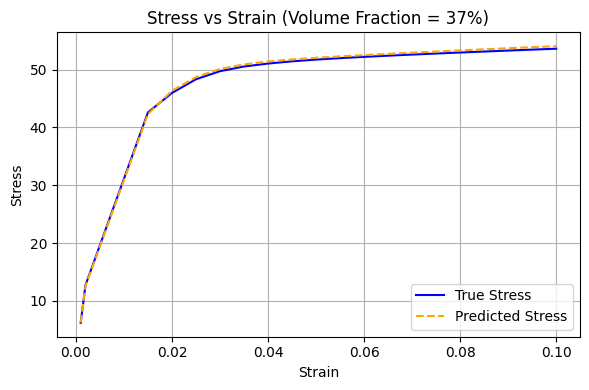

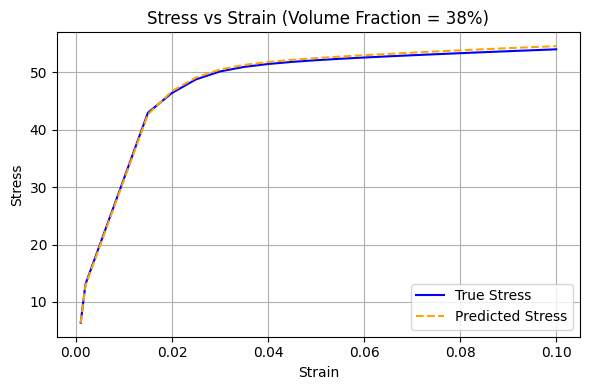

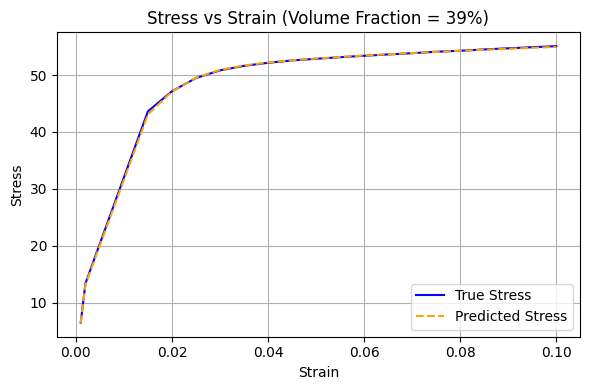

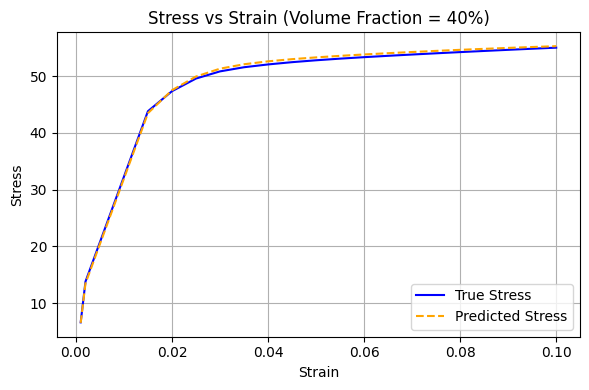

In [ ]:
# Set the model to evaluation mode (no gradients, dropout off)
model.eval()

# Get all unique volume fractions
unique_vf = sorted(df['Volume_Fraction'].unique())

# Loop through each volume fraction group
for vf in unique_vf:
    # Filter the data for the current volume fraction
    group = df[df['Volume_Fraction'] == vf]

    # Extract inputs and true strain
    x_group = group[['X1', 'X2']].values         # Normalized volume fraction and strain
    y_true = group[['Stress']].values            # Actual stress values (not scaled)
    strain = group['Strain'].values              # For x-axis in plot

    # Convert input to tensor and add batch dimension
    x_tensor = torch.tensor(x_group, dtype=torch.float32).unsqueeze(0).to(device)

    # Make predictions with the trained RNN
    with torch.no_grad():
        y_pred_scaled, _ = model(x_tensor)       # Output is still scaled
        y_pred_scaled = y_pred_scaled.squeeze(0).cpu().numpy()

    # Inverse scale the predicted strain to original units
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Plot true vs. predicted strain for this volume fraction
    plt.figure(figsize=(6, 4))
    plt.plot(strain, y_true, label='True Stress', color='blue')
    plt.plot(strain, y_pred, label='Predicted Stress', color='orange', linestyle='--')
    plt.ylabel("Stress")
    plt.xlabel("Strain")
    plt.title(f"Stress vs Strain (Volume Fraction = {vf}%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()